In [1]:
#Imports all needed packages 
from pathlib import Path
from datatree import DataTree
import dask
import xarray as xr
import pandas as pd
import valenspy as vp
import numpy as nps
from pathlib import Path
import geopandas as gpd
import rioxarray 
from valenspy.cf_checks import is_cf_compliant, cf_status


# Evaluation of the ALARO-0 Model for Water Cycle Analysis in Belgium

## Introduction

This notebook aims to evaluate the performance of the ALARO-0 model in simulating the water cycle over Belgium. The ALARO-0 model is part of the ALADIN consortium and has been specifically developed to run at convection-permitting resolutions. This evaluation will include a comprehensive analysis of the model's ability to simulate various components of the water cycle, including precipitation, evaporation, and runoff.

The study will use model output from the ALARO-0 model, observational data from the Royal Meteorological Institute of Belgium (RMI), and additional data from ERA5 reanalysis (to be integrated later). The evaluation will involve spatial and temporal analyses, statistical evaluations, and the identification and analysis of extreme events.

### Data Description
- **Model Data**: ALARO-0 model outputs (1980-2010)
- **Observational Data**: Gridded observations from RMI (1954-2021)
- **Additional Data**: ERA5 reanalysis data (to be integrated later)

### Study Area
- **Region**: Belgium

## Structure of the Notebook
1. Data Preparation
2. Spatial Analysis
3. Water Budget Components
4. Statistical Evaluation
5. Temporal Analysis
6. Extreme Events Analysis
7. Visualization and Presentation
8. Conclusion


## 1. Data Preparation


In [2]:
import xarray as xr
import geopandas as gpd

# Load ALARO-0 model data
model_files = list(Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/ALARO-0_RMIB-UGent/ncdf_GeertLenderink/ERAINT_1980_2010/").rglob("*.nc"))
alaro_ds = xr.open_mfdataset(model_files, chunks="auto")

# Load observational data
obs_ds = xr.open_mfdataset("/mnt/HDS_FORESTFLOW/FORESTFLOW/CLIMATE_GRID/SYLVAIN/Daily*.nc", chunks="auto")

# Load Belgian borders
# shapefile_path = "/home/kabruyn/fileserver/home/ValEnsPy/examples/Belgium_shapefile/be_1km.shp"
# belgium_gdf = gpd.read_file(shapefile_path)
boundaries = "/mnt/HDS_CLIMATE/CLIMATE/nicghil/LandPrepSurfex/Shapefiles/"

# Load DEM data => too advanced after feedback
# dem_path = "/home/kabruyn/fileserver/home/ValEnsPy/examples/DTM_20m/DTM_20m.tif"  
#dem = rioxarray.open_rasterio(dem_path)

In [69]:
# Importing all at once is not feasable since different time_bnds
era5_land_files = list(Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily").rglob("*max*.nc"))
print(era5_land_files)
era5_land_ds = xr.open_mfdataset(era5_land_files, chunks="auto")

[PosixPath('/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily/surface_net_solar_radiation/era5-land-daily_max-belgium-surface_net_solar_radiation-1950.nc'), PosixPath('/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily/surface_net_solar_radiation/era5-land-daily_max-belgium-surface_net_solar_radiation-1951.nc'), PosixPath('/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily/surface_net_solar_radiation/era5-land-daily_max-belgium-surface_net_solar_radiation-1952.nc'), PosixPath('/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily/surface_net_solar_radiation/era5-land-daily_max-belgium-surface_net_solar_radiation-1953.nc'), PosixPath('/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily/surface_net_solar_radiation/era5-land-daily_max-belgium-surface_net_solar_radiation-1954.nc'), PosixPath('/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily/surface_net_solar_radiation/era5-land-daily_max-belgium-surfac

MergeError: conflicting values for variable 'time_bnds' on objects to be combined. You can skip this check by specifying compat='override'.

In [7]:
# Importing including combine by coordinates 
from pathlib import Path
import xarray as xr

# Define the path to the ERA5 and ERA5-Land data directories
era5_path = Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5/belgium/daily")
era5_land_path = Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily")

# Filter to select only 'max' files to avoid conflicts
era5_files = list(era5_path.rglob("*max*.nc"))
era5_land_files = list(era5_land_path.rglob("*max*.nc"))

# Load the datasets using xarray
era5_ds = xr.open_mfdataset(era5_files, chunks="auto", combine='by_coords')
era5_land_ds = xr.open_mfdataset(era5_land_files, chunks="auto", combine='by_coords')

# Print the datasets to verify successful loading
print(era5_ds)
print(era5_land_ds)


MergeError: conflicting values for variable 'time_bnds' on objects to be combined. You can skip this check by specifying compat='override'.

In [5]:
# Importing data with compat override and without taking max, compat override is not a good idea
# Load ERA 5 data 
era5_files = list(Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5/belgium/daily").rglob("*.nc"))
era5_ds = xr.open_mfdataset(era5_files, chunks="auto", compat='override')

# Load ERA 5 land data
era5_land_files = list(Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily").rglob("*.nc"))
era5_land_ds = xr.open_mfdataset(era5_land_files, chunks="auto", compat='override')

ValueError: Cannot specify both coords='different' and compat='override'.

In [31]:
# Importing all parameters seperatly
from pathlib import Path
import xarray as xr

# Define base directory
base_dir = Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily")

# List of parameters to import
parameters = [
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "2m_dewpoint_temperature",
    "2m_temperature",
    "evaporation",
    "potential_evaporation",
    "runoff",
    "skin_temperature",
    "snow_depth",
    "snowfall",
    "surface_latent_heat_flux",
    "surface_net_solar_radiation",
    "surface_pressure",
    "surface_runoff",
    "surface_sensible_heat_flux",
    "surface_solar_radiation_downwards",
    "total_precipitation",
    "volumetric_soil_water_layer_1"
]

# Load datasets
datasets = {}
for param in parameters:
    files = list(base_dir.joinpath(param).rglob("*.nc"))
    ds = xr.open_mfdataset(files, chunks="auto", combine='by_coords')
    datasets[param] = ds


In [32]:
# Give all of them a name
ds_10m_u_component_of_wind = datasets["10m_u_component_of_wind"]
ds_10m_v_component_of_wind = datasets["10m_v_component_of_wind"]
ds_2m_dewpoint_temperature = datasets["2m_dewpoint_temperature"]
ds_2m_temperature = datasets["2m_temperature"]
ds_evaporation = datasets["evaporation"]
ds_potential_evaporation = datasets["potential_evaporation"]
ds_runoff = datasets["runoff"]
ds_skin_temperature = datasets["skin_temperature"]
ds_snow_depth = datasets["snow_depth"]
ds_snowfall = datasets["snowfall"]
ds_surface_latent_heat_flux = datasets["surface_latent_heat_flux"]
ds_surface_net_solar_radiation = datasets["surface_net_solar_radiation"]
ds_surface_pressure = datasets["surface_pressure"]
ds_surface_runoff = datasets["surface_runoff"]
ds_surface_sensible_heat_flux = datasets["surface_sensible_heat_flux"]
ds_surface_solar_radiation_downwards = datasets["surface_solar_radiation_downwards"]
ds_total_precipitation = datasets["total_precipitation"]
ds_volumetric_soil_water_layer_1 = datasets["volumetric_soil_water_layer_1"]

In [33]:
ds_10m_u_component_of_wind

<xarray.Dataset> Size: 108MB
Dimensions:    (time: 26298, bnds: 2, latitude: 25, longitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 210kB 1950-01-01T12:00:00 ... 2021-12-31...
  * longitude  (longitude) float32 164B 2.0 2.125 2.25 2.375 ... 6.75 6.875 7.0
  * latitude   (latitude) float32 100B 52.0 51.88 51.75 ... 49.25 49.12 49.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 421kB dask.array<chunksize=(365, 2), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 108MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Nov 02 15:56:25 2023: cdo -z zip daymin /scratch/bertvs...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...

ERA 5 import zonder time_bnds

In [3]:
import xarray as xr
from pathlib import Path

# Function to preprocess files and remove 'time_bnds'
def preprocess(ds):
    return ds.drop_vars('time_bnds', errors='ignore')

# Load ERA 5 land data with preprocessing to drop 'time_bnds'
era5_land_files = list(Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily").rglob("*.nc"))
era5_land_ds = xr.open_mfdataset(era5_land_files, chunks="auto", preprocess=preprocess)


In [4]:
era5_land_ds

<xarray.Dataset> Size: 7GB
Dimensions:    (time: 52596, longitude: 41, latitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 421kB 1950-01-01T11:00:00 ... 2021-12-31...
  * longitude  (longitude) float32 164B 2.0 2.125 2.25 2.375 ... 6.75 6.875 7.0
  * latitude   (latitude) float32 100B 52.0 51.88 51.75 ... 49.25 49.12 49.0
Data variables: (12/18)
    d2m        (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    e          (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    pev        (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    ro         (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    sde        (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    sf         (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    ...         ...
    ssrd       (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    t2m        (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    tp         (time, latitude, longitude) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 216MB dask.array<chunksize=(731, 25, 41), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 216MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Sep 05 05:06:06 2022: cdo -z zip daymin /mnt/HDS_BREGIL...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

# ERA5 input convertor

In [63]:
from pathlib import Path

import xarray as xr
import pandas as pd
#hallo
import valenspy as vp #The Valenspy package
from valenspy.inputconverter_functions import _non_convertor, ERA5_to_CF

from yaml import safe_load
from typing import Union, List


In [64]:
#Import Converter - This input converter will not do anything to the data.
ic = vp.InputConverter(ERA5_to_CF)

In [75]:
machine = "kili"


# User defined variable, here we look at 2m temperature. 
variable = "t2m"
dataset = "ERA5"
region = "belgium" # "belgium"
time_freq = "daily" ## Important to account here are the postprocessed files at daily time resolution and their naming (eg max daily temperature does not correspond to ERA5 variable name as defined!!)

In [76]:
from pathlib import Path
from yaml import safe_load

src_path = Path("/home/kabruyn/fileserver/home/ValEnsPy/src/valenspy")

# Load CORDEX variables
with open(src_path / "ancilliary_data" / "CORDEX_variables.yml") as file:
    CORDEX_VARIABLES = safe_load(file)

# Determine dataset lookup
dataset_lookup = 'ERA5' if dataset == 'ERA5-Land' else dataset

# Load lookup table for the dataset
with open(src_path / "ancilliary_data" / Path(f"{dataset_lookup}_lookup.yml")) as file:
    obs_LOOKUP = safe_load(file)

# Continue with the rest of your workflow...


In [71]:
# this will be part of the PATH generator. 

# get path of observational datasets from path settings .yml
with open(src_path / "ancilliary_data" / Path("dataset_PATHS.yml")) as file:
    dataset_PATHS = safe_load(file)
directory = dataset_PATHS[machine][dataset]

# get ERA5 variable corresponding to the requested variable using its look-up table
obs_var = obs_LOOKUP[variable]['obs_name']

# get ERA5 subdirectory
subdirectory = Path(directory + '/' + region +'/'+time_freq+'/'+obs_LOOKUP[variable]['obs_long_name']+'/')

# open the EOBS file for the corresponding variable
files = list(subdirectory.glob("*-"+time_freq+"-*"+obs_LOOKUP[variable]['obs_long_name']+"*20*.nc")) #Select all the netCDF files in the directory
files

KeyError: 't2m'

In [72]:
# test of ERA5 convertor function
ERA5_ds = ic.convert_input(ds_2m_temperature) #Convert the input to the correct format
ERA5_ds

KeyError: "No variable named 0. Variables on the dataset include ['time_bnds', 't2m', 'time', 'longitude', 'latitude']"

In [18]:
from pathlib import Path
import xarray as xr
import pandas as pd
import valenspy as vp
from valenspy.inputconverter_functions import ERA5_to_CF
from yaml import safe_load
from typing import Union, List

# Define base directory
base_dir = Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily")

# List of parameters to import
parameters = [
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "2m_dewpoint_temperature",
    "2m_temperature",
    "evaporation",
    "potential_evaporation",
    "runoff",
    "skin_temperature",
    "snow_depth",
    "snowfall",
    "surface_latent_heat_flux",
    "surface_net_solar_radiation",
    "surface_pressure",
    "surface_runoff",
    "surface_sensible_heat_flux",
    "surface_solar_radiation_downwards",
    "total_precipitation",
    "volumetric_soil_water_layer_1"
]

# Load datasets
datasets = {}
for param in parameters:
    files = list(base_dir.joinpath(param).rglob("*.nc"))
    ds = xr.open_mfdataset(files, chunks="auto", combine='by_coords')
    datasets[param] = ds

# Print loaded datasets to verify
print("Loaded datasets keys:", datasets.keys())



Loaded datasets keys: dict_keys(['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'evaporation', 'potential_evaporation', 'runoff', 'skin_temperature', 'snow_depth', 'snowfall', 'surface_latent_heat_flux', 'surface_net_solar_radiation', 'surface_pressure', 'surface_runoff', 'surface_sensible_heat_flux', 'surface_solar_radiation_downwards', 'total_precipitation', 'volumetric_soil_water_layer_1'])


In [19]:
# Input Converter setup
ic = vp.InputConverter(ERA5_to_CF)
machine = "hortense"

# User defined variable, here we look at 2m temperature.
variable = "tas"
dataset = "ERA5"
region = "belgium"
time_freq = "daily"

src_path = Path("/home/kabruyn/fileserver/home/ValEnsPy/src/valenspy")

# Load CORDEX variables
with open(src_path / "ancilliary_data" / "CORDEX_variables.yml") as file:
    CORDEX_VARIABLES = safe_load(file)

# Determine dataset lookup
dataset_lookup = 'ERA5' if dataset == 'ERA5-Land' else dataset

# Load lookup table for the dataset
with open(src_path / "ancilliary_data" / Path(f"{dataset_lookup}_lookup.yml")) as file:
    obs_LOOKUP = safe_load(file)

# Print obs_LOOKUP for debugging
print("obs_LOOKUP:", obs_LOOKUP)

# Get path of observational datasets from path settings .yml
with open(src_path / "ancilliary_data" / Path("dataset_PATHS.yml")) as file:
    dataset_PATHS = safe_load(file)
directory = dataset_PATHS[machine][dataset]

# Get ERA5 variable corresponding to the requested variable using its look-up table
obs_var = obs_LOOKUP[variable]['obs_name']

# Print obs_var to ensure it matches datasets keys
print("obs_var:", obs_var)

# Get ERA5 subdirectory
subdirectory = Path(directory + '/' + region + '/' + time_freq + '/' + obs_LOOKUP[variable]['obs_long_name'] + '/')

# Open the EOBS file for the corresponding variable
files = list(subdirectory.glob("*-" + time_freq + "-*" + obs_LOOKUP[variable]['obs_long_name'] + "*20*.nc"))

# Print files to ensure they are correctly identified
print("Files found:", files)

# Test of ERA5 converter function
if obs_var in datasets:
    ERA5_ds = ic.convert_input(datasets[obs_var])  # Convert the input to the correct format
    print(ERA5_ds)
else:
    print(f"Key '{obs_var}' not found in datasets. Available keys: {datasets.keys()}")



obs_LOOKUP: {'pr': {'obs_name': 'tp', 'obs_long_name': 'total_precipitation', 'obs_units': 'm/hr'}, 'prsn': {'obs_name': 'sf', 'obs_long_name': 'snowfall', 'obs_units': 'm/hr'}, 'prw': {'obs_name': 'tcwv', 'obs_long_name': 'total_column_water_vapour', 'obs_units': 'mm'}, 'snw': {'obs_name': 'sd', 'obs_long_name': 'snow_depth', 'obs_units': 'cm'}, 'snd': {'obs_name': 'sd', 'obs_long_name': 'snow_depth_water_equivalent', 'obs_units': 'm'}, 'mrros': {'obs_name': 'sro', 'obs_long_name': 'surface_runoff', 'obs_units': 'm/hr'}, 'mrro': {'obs_name': 'ro', 'obs_long_name': 'runoff', 'obs_units': 'm/hr'}, 'tas': {'obs_name': 't2m', 'obs_long_name': '2m_temperature', 'obs_units': 'K'}, 'ts': {'obs_name': 'skt', 'obs_long_name': 'skin_temperature', 'obs_units': 'K'}, 'evspsbl': {'obs_name': 'e', 'obs_long_name': 'evaporation', 'obs_units': 'm/hr'}, 'evspsblpot': {'obs_name': 'pev', 'obs_long_name': 'potential_evaporation', 'obs_units': 'm/hr'}, 'uas': {'obs_name': '10u', 'obs_long_name': '10m_u_c

# ERA5 data temporarly

In [3]:
vars_to_load=["2m_temperature", "10m_u_component_of_wind", "surface_pressure"] #It seems that loading total_precipitation, evapotraion is not working properly! To be investigated why.
files=[]
for var in vars_to_load:
    files += list(Path(f"/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily/{var}").glob("*max*.nc"))
era5_land_files = list(files)

In [4]:
era5_land_ds = xr.open_mfdataset(era5_land_files, chunks="auto")
era5_land_ds

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 52595, longitude: 41, latitude: 25, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 421kB 1950-01-01T12:00:00 ... 2021-12-31...
  * longitude  (longitude) float32 164B 2.0 2.125 2.25 2.375 ... 6.75 6.875 7.0
  * latitude   (latitude) float32 100B 52.0 51.88 51.75 ... 49.25 49.12 49.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 842kB dask.array<chunksize=(729, 2), meta=np.ndarray>
    sp         (time, latitude, longitude) float64 431MB dask.array<chunksize=(729, 25, 41), meta=np.ndarray>
    t2m        (time, latitude, longitude) float64 431MB dask.array<chunksize=(729, 25, 41), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 216MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Sep 05 05:26:16 2022: cdo -z zip daymax /mnt/HDS_BREGIL...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [5]:
var="total_precipitation"
var_list = list(Path(f"/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily/{var}").glob("*max*.nc"))
var_ds = xr.open_mfdataset(var_list, chunks="auto")
var_ds 

<xarray.Dataset> Size: 216MB
Dimensions:    (time: 26298, bnds: 2, latitude: 25, longitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 210kB 1950-01-01T11:00:00 ... 2021-12-31...
  * longitude  (longitude) float32 164B 2.0 2.125 2.25 2.375 ... 6.75 6.875 7.0
  * latitude   (latitude) float32 100B 52.0 51.88 51.75 ... 49.25 49.12 49.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 421kB dask.array<chunksize=(365, 2), meta=np.ndarray>
    tp         (time, latitude, longitude) float64 216MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Sep 05 05:32:53 2022: cdo -z zip daymax /scratch/bertvs...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

# ALERO IMPORT 

In [26]:
# Define the path to the CSV file
csv_path = "/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/CORDEX_runs_meta_belgium_day_eval_karian.csv"

# Load the CSV file into a pandas DataFrame
cordex_runs_meta = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
print("CORDEX Runs Meta Data:")
print(cordex_runs_meta.head())


CORDEX Runs Meta Data:
  domain rcm_institute     gcm_model  experiment ensemble  \
0  be-04      KULeuven  ECMWF-ERAINT  evaluation   r1i1p1   
1  be-04      KULeuven  ECMWF-ERAINT  evaluation   r1i1p1   
2  be-04      KULeuven  ECMWF-ERAINT  evaluation   r1i1p1   
3  be-04      KULeuven  ECMWF-ERAINT  evaluation   r1i1p1   
4  be-04      KULeuven  ECMWF-ERAINT  evaluation   r1i1p1   

             rcm_model rcm_version time_frequency variable  \
0  COSMO-5.0-TERRA-URB          v1            day     cape   
1  COSMO-5.0-TERRA-URB          v1            day      clt   
2  COSMO-5.0-TERRA-URB          v1            day     huss   
3  COSMO-5.0-TERRA-URB          v1            day       pr   
4  COSMO-5.0-TERRA-URB          v1            day     prsn   

                                            dir.name  \
0  be-04/KULeuven/ECMWF-ERAINT/evaluation/r1i1p1/...   
1  be-04/KULeuven/ECMWF-ERAINT/evaluation/r1i1p1/...   
2  be-04/KULeuven/ECMWF-ERAINT/evaluation/r1i1p1/...   
3  be-04/KULe

# importing of KULeuven set

In [78]:
import xarray as xr
from pathlib import Path

# Define the path to the KULeuven model data
kul_path = Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/KULeuven")

# Get a list of all NetCDF files in the directory and subdirectories
kul_model_files = list(kul_path.rglob("*.nc"))

# Initialize lists to store files with common dimensions and filtered out files
filtered_files = []
filtered_out_files = []

# Loop through each file and load its dataset to check dimensions and coordinates
for file in kul_model_files:
    ds = xr.open_dataset(file)
    # Extract dimensions (excluding coordinates)
    dimensions = set(ds.dims.keys())
    # Check if the dimensions match the common dimensions (bnds, lat, lon, time, level)
    common_dims = {'bnds', 'lat', 'lon', 'time'}
    if dimensions.issuperset(common_dims):
        filtered_files.append(file)
    else:
        filtered_out_files.append(file)
    ds.close()  # Close the dataset to release resources

# Print the number of filtered files
print(f"Number of filtered NetCDF files: {len(filtered_files)}")
print(f"Number of filtered out NetCDF files: {len(filtered_out_files)}")

# Print the list of filtered out files
print("Filtered out files:")
for file in filtered_out_files:
    print(file)

# Attempt to open the dataset with mfdataset using the filtered files
kul_ds = xr.open_mfdataset(filtered_files, combine='by_coords', chunks='auto')

# Print dimensions and coordinates of the combined dataset
print("Combined dataset dimensions:", kul_ds.dims)
print("Combined dataset coordinates:", kul_ds.coords)



/tmp/ipykernel_1773637/4099253690.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_1773637/4099253690.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_1773637/4099253690.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_1773637/4099253690.

Number of filtered NetCDF files: 682
Number of filtered out NetCDF files: 19
Filtered out files:
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/KULeuven/ECMWF-ERAINT/evaluation/r1i1p1/COSMO-5.0-TERRA-URB/v1/day/cape/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/KULeuven/ECMWF-ERAINT/evaluation/r1i1p1/COSMO-5.0-TERRA-URB/v1/day/clt/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/KULeuven/ECMWF-ERAINT/evaluation/r1i1p1/COSMO-5.0-TERRA-URB/v1/day/huss/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/KULeuven/ECMWF-ERAINT/evaluation/r1i1p1/COSMO-5.0-TERRA-URB/v1/day/pr/con_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/KULeuven/ECMWF-ERAINT/evaluation/r1i1p1/COSMO-5.0-TERRA-URB/v1/day/prsn/con_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX

In [79]:
kul_ds

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 39447, lon: 41, lat: 25, bnds: 2, lev: 1, level: 1)
Coordinates:
  * time       (time) datetime64[ns] 316kB 1979-01-01T09:00:00 ... 2014-12-31...
  * lon        (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat        (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
  * lev        (lev) float64 8B 39.0
Dimensions without coordinates: bnds, level
Data variables: (12/20)
    time_bnds  (time, bnds) datetime64[ns] 631kB dask.array<chunksize=(1095, 2), meta=np.ndarray>
    cape       (time, lat, lon) float32 162MB dask.array<chunksize=(1097, 25, 41), meta=np.ndarray>
    clt        (time, lat, lon) float32 162MB dask.array<chunksize=(1097, 25, 41), meta=np.ndarray>
    huss       (time, lat, lon) float32 162MB dask.array<chunksize=(1096, 25, 41), meta=np.ndarray>
    pr         (time, lat, lon) float32 162MB dask.array<chunksize=(1097, 25, 41), meta=np.ndarray>
    prsn       (time, lat, lon) float32 162MB dask.array<chunksize=(1097, 25, 41), meta=np.ndarray>
    ...         ...
    tasmin     (time, lat, lon) float32 162MB dask.array<chunksize=(1096, 25, 41), meta=np.ndarray>
    ts         (time, lat, lon) float32 162MB dask.array<chunksize=(1096, 25, 41), meta=np.ndarray>
    uas        (time, lev, lat, lon) float32 162MB dask.array<chunksize=(1096, 1, 25, 41), meta=np.ndarray>
    vas        (time, lev, lat, lon) float32 162MB dask.array<chunksize=(1096, 1, 25, 41), meta=np.ndarray>
    zhd        (time, level, lat, lon) float32 162MB dask.array<chunksize=(1096, 1, 25, 41), meta=np.ndarray>
    zwd        (time, level, lat, lon) float32 162MB dask.array<chunksize=(1096, 1, 25, 41), meta=np.ndarray>
Attributes: (12/14)
    CDI:             Climate Data Interface version 1.9.9 (https://mpimet.mpg...
    Conventions:     CF-1.4
    title:           CORDEX.BE-0025
    project_id:      CORDEX.BE-0025
    experiment_id:   CORDEX.BE-URB2000
    realization:     1
    ...              ...
    references:      http://ees.kuleuven.be/geography/rcs/
    creation_date:   2015-10-03 03:15:50
    history:         Tue May 28 21:41:42 2024: cdo -z zip remap,/home/bertvs/...
    NCO:             "4.5.4"
    frequency:       day
    CDO:             Climate Data Operators version 1.9.9 (https://mpimet.mpg...

# Importing of RMIB_UGent

In [10]:
import xarray as xr
from pathlib import Path

# Define the path to the RMIB-UGent model data
rmib_path = Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/RMIB-UGent")

# Get a list of all NetCDF files in the directory and subdirectories
rmib_model_files = list(rmib_path.rglob("*.nc"))

# Initialize lists to store relevant and irrelevant files
relevant_files = []
irrelevant_files = []

# Loop through each file and load its dataset to check dimensions and coordinates
for file in rmib_model_files:
    try:
        ds = xr.open_dataset(file)
        # Extract dimensions (excluding coordinates)
        dimensions = set(ds.dims.keys())
        # Check if the dimensions match the common dimensions (bnds, lat, lon, time)
        irrelevant_dims = {'dst_grid_rank', 'dst_grid_size', 'num_links', 'num_wgts', 'src_grid_rank', 'src_grid_size'}
        if dimensions.isdisjoint(irrelevant_dims):
            relevant_files.append(file)
        else:
            irrelevant_files.append(file)
        ds.close()  # Close the dataset to release resources
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        irrelevant_files.append(file)

# Print the number of relevant files
print(f"Number of relevant NetCDF files: {len(relevant_files)}")
print(f"Number of irrelevant NetCDF files: {len(irrelevant_files)}")

# Print the list of irrelevant files
print("Irrelevant files:")
for file in irrelevant_files:
    print(file)

# Attempt to open the dataset with mfdataset using the relevant files, filtering out 'height', 'plev', and 'plev_bnds'
rmib_ds = xr.open_mfdataset(relevant_files, combine='by_coords', chunks='auto', drop_variables=['height', 'plev', 'plev_bnds'])

# Print dimensions and coordinates of the combined dataset
print("Combined dataset dimensions:", rmib_ds.dims)
print("Combined dataset coordinates:", rmib_ds.coords)



/tmp/ipykernel_527609/2270925865.py:19: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_527609/2270925865.py:19: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_527609/2270925865.py:19: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_527609/2270925865.py:1

Number of relevant NetCDF files: 1472
Number of irrelevant NetCDF files: 46
Irrelevant files:
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/RMIB-UGent/ECMWF-ERAINT/evaluation/r1i1p1/ALARO-0/v1/day/clh/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/RMIB-UGent/ECMWF-ERAINT/evaluation/r1i1p1/ALARO-0/v1/day/clivi/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/RMIB-UGent/ECMWF-ERAINT/evaluation/r1i1p1/ALARO-0/v1/day/cll/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/RMIB-UGent/ECMWF-ERAINT/evaluation/r1i1p1/ALARO-0/v1/day/clm/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/RMIB-UGent/ECMWF-ERAINT/evaluation/r1i1p1/ALARO-0/v1/day/clt/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/RMIB-UGe

In [11]:
rmib_ds

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 11688, bnds: 2, lat: 25, lon: 41)
Coordinates:
  * time        (time) datetime64[ns] 94kB 1979-01-01T12:00:00 ... 2010-12-31...
  * lon         (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat         (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
Dimensions without coordinates: bnds
Data variables: (12/47)
    time_bnds   (time, bnds) datetime64[ns] 187kB dask.array<chunksize=(365, 2), meta=np.ndarray>
    clh         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    clivi       (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    cll         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    clm         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    clt         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    ...          ...
    tauv        (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    ts          (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    uas         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    vas         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    wsgsmax     (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    zmla        (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
Attributes: (12/26)
    CDI:                            Climate Data Interface version 1.9.9 (htt...
    institution:                    Royal Meteorological Institute of Belgium...
    Conventions:                    CF-1.6
    institute_id:                   RMIB-UGent
    model_id:                       RMIB-UGent-ALARO-0
    experiment_id:                  evaluation
    ...                             ...
    creation_date:                  2017-01-05T15:00:14Z
    tracking_id:                    32498d3e-4587-4282-92a5-7253bf41af11
    driving_experiment:             ECMWF-ERAINT, ERAINT, r1i1p1
    CORDEX_domain:                  be-04
    history:                        Tue May 28 21:58:19 2024: cdo -z zip rema...
    CDO:                            Climate Data Operators version 1.9.9 (htt...

# Importing of UCL data

In [6]:
import xarray as xr
from pathlib import Path

# Define the path to the UCL model data
ucl_path = Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/UCL")

# Get a list of all NetCDF files in the directory and subdirectories
ucl_model_files = list(ucl_path.rglob("*.nc"))

# Initialize lists to store files with common dimensions and filtered out files
filtered_files = []
filtered_out_files = []

# Loop through each file and load its dataset to check dimensions and coordinates
for file in ucl_model_files:
    try:
        ds = xr.open_dataset(file)
        # Extract dimensions (excluding coordinates)
        dimensions = set(ds.dims.keys())
        # Check if the dimensions match the common dimensions (bnds, lat, lon, time)
        common_dims = {'bnds', 'lat', 'lon', 'time'}
        if dimensions.issuperset(common_dims):
            filtered_files.append(file)
        else:
            filtered_out_files.append(file)
        ds.close()  # Close the dataset to release resources
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        filtered_out_files.append(file)

# Print the number of filtered files
print(f"Number of filtered NetCDF files: {len(filtered_files)}")
print(f"Number of filtered out NetCDF files: {len(filtered_out_files)}")

# Print the list of filtered out files
print("Filtered out files:")
for file in filtered_out_files:
    print(file)

# Attempt to open the dataset with mfdataset using the filtered files, filtering out 'time_bnds'
ucl_ds = xr.open_mfdataset(filtered_files, combine='by_coords', chunks='auto', drop_variables=['time_bnds'])

# Print dimensions and coordinates of the combined dataset
print("Combined dataset dimensions:", ucl_ds.dims)
print("Combined dataset coordinates:", ucl_ds.coords)


/tmp/ipykernel_527609/157748041.py:19: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_527609/157748041.py:19: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_527609/157748041.py:19: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dimensions = set(ds.dims.keys())
/tmp/ipykernel_527609/157748041.py:19: F

Number of filtered NetCDF files: 930
Number of filtered out NetCDF files: 30
Filtered out files:
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/UCL/ECMWF-ERAINT/evaluation/r1i1p1/CCLM5.0/v1/day/cape/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/UCL/ECMWF-ERAINT/evaluation/r1i1p1/CCLM5.0/v1/day/clt/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/UCL/ECMWF-ERAINT/evaluation/r1i1p1/CCLM5.0/v1/day/dewT/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/UCL/ECMWF-ERAINT/evaluation/r1i1p1/CCLM5.0/v1/day/evspsbl/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/UCL/ECMWF-ERAINT/evaluation/r1i1p1/CCLM5.0/v1/day/hffs/bil_weights.nc
/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/UCL/ECMWF-ERAINT/evaluation/r1i1p1/

In [7]:
ucl_ds

<xarray.Dataset> Size: 9GB
Dimensions:     (time: 56584, lon: 41, lat: 25, soil1: 10, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 453kB 1980-01-01 ... 2010-12-31T11:30:00
  * lon         (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat         (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
    height_2m   float32 4B 2.0
  * soil1       (soil1) float32 40B 0.005 0.025 0.07 0.16 ... 2.86 5.74 11.5
    height_10m  float32 4B 10.0
Dimensions without coordinates: bnds
Data variables: (12/32)
    RAIN_GSP    (time, lat, lon) float32 232MB dask.array<chunksize=(3659, 25, 41), meta=np.ndarray>
    cape        (time, lat, lon) float32 232MB dask.array<chunksize=(1834, 25, 41), meta=np.ndarray>
    clt         (time, lat, lon) float32 232MB dask.array<chunksize=(1834, 25, 41), meta=np.ndarray>
    dewT        (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    evspsbl     (time, lat, lon) float32 232MB dask.array<chunksize=(1831, 25, 41), meta=np.ndarray>
    hffs        (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    ...          ...
    tasmin      (time, lat, lon) float32 232MB dask.array<chunksize=(1830, 25, 41), meta=np.ndarray>
    ts          (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    uas         (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    vas         (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    wsgsmax     (time, lat, lon) float32 232MB dask.array<chunksize=(1830, 25, 41), meta=np.ndarray>
    zmla        (time, lat, lon) float32 232MB dask.array<chunksize=(1832, 25, 41), meta=np.ndarray>
Attributes: (12/15)
    CDI:             Climate Data Interface version 1.9.9 (https://mpimet.mpg...
    source:          cosmo_131108_5.00_clm1, int2lm_131101_2.00_clm1
    institution:     Université Catholique de Louvain
    Conventions:     CF-1.4
    title:           EUROCORDEX-011
    project_id:      CORDEX.BE-0025
    ...              ...
    contact:         Cecille Villanueva (cecille.villanueva@uclouvain.be)
    references:      http://www.clm-community.eu/
    creation_date:   2016-09-14 07:26:44
    history:         Tue May 28 22:16:03 2024: cdo -z zip remap,/home/bertvs/...
    frequency:       day
    CDO:             Climate Data Operators version 1.9.9 (https://mpimet.mpg...

# Obs first version

In [21]:
#Visualize dataset observations
obs_ds

<xarray.Dataset> Size: 4GB
Dimensions:          (time: 24837, lat: 64, lon: 73)
Coordinates:
  * lon              (lon) float64 584B 2.45 2.508 2.565 ... 6.485 6.542 6.6
  * lat              (lat) float64 512B 49.35 49.39 49.42 ... 51.58 51.61 51.65
  * time             (time) datetime64[ns] 199kB 1954-01-01 ... 2021-12-31
    spatial_ref      int64 8B 0
Data variables:
    PRECIP_QUANTITY  (time, lat, lon) float64 928MB dask.array<chunksize=(365, 64, 73), meta=np.ndarray>
    TEMP_AVG         (time, lat, lon) float64 928MB dask.array<chunksize=(365, 64, 73), meta=np.ndarray>
    TEMP_MAX         (time, lat, lon) float64 928MB dask.array<chunksize=(365, 64, 73), meta=np.ndarray>
    TEMP_MIN         (time, lat, lon) float64 928MB dask.array<chunksize=(365, 64, 73), meta=np.ndarray>
Attributes:
    Creators:                     Ghilain N., Van Schaeybroeck B., Marchi S.
    Version:                      1.1
    Affiliation:                  Royal Meteorological Institute of Belgium
    Url:                          https://opendata.meteo.be/geonetwork/srv/en...
    Coordinate reference system:  EPSG:4258
    Identifier:                   RMI_DATASET_GRIDDEDOBS

IMPORT EOBS data

In [2]:
# Load EOBS model data
model_files = list(Path("/mnt/HDS_URCLIM/URCLIM/obs/gridded/domain/belgium/pr/eobs/v29.0e_0.1deg_ens_mean/day/per_yr").rglob("*.nc"))
eobs_pr_ds = xr.open_mfdataset(model_files, chunks="auto")

# Load EOBS model data
model_files = list(Path("/mnt/HDS_URCLIM/URCLIM/obs/gridded/domain/belgium/tas/eobs/v29.0e_0.1deg_ens_mean/day/per_yr").rglob("*.nc"))
eobs_tas_ds = xr.open_mfdataset(model_files, chunks="auto")

In [3]:
eobs_tas_ds

<xarray.Dataset> Size: 111MB
Dimensions:  (time: 27028, lat: 25, lon: 41)
Coordinates:
  * time     (time) datetime64[ns] 216kB 1950-01-01 1950-01-02 ... 2023-12-31
  * lon      (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat      (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
Data variables:
    tg       (time, lat, lon) float32 111MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.9.9 (https://mpimet.mpg....
    Conventions:    CF-1.4
    history:        Tue Jun 11 11:42:02 2024: cdo remap,/mnt/netapp/home/bert...
    E-OBS_version:  29.0e
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....
    CDO:            Climate Data Operators version 1.9.9 (https://mpimet.mpg....

In [4]:
eobs_pr_ds

<xarray.Dataset> Size: 111MB
Dimensions:  (time: 27028, lat: 25, lon: 41)
Coordinates:
  * time     (time) datetime64[ns] 216kB 1950-01-01 1950-01-02 ... 2023-12-31
  * lon      (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat      (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
Data variables:
    pp       (time, lat, lon) float32 111MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jun 11 11:52:02 2024: cdo remap,/mnt/netapp/home/bertvs...
    NCO:          netCDF Operators version 5.1.4 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

# STOP import and start analysis

## 2. Spatial Analysis


The Alero data need to be changed so that it only covers Belgium and thus is less computational intensive.

Subset ALARO-0 model data dimensions: FrozenMappingWarningOnValuesAccess({'time': 543504, 'y': 20, 'x': 23, 'bnds': 2})
Subset ALARO-0 model data coordinates: Coordinates:
  * x        (x) float64 184B 2.5e+03 2.512e+03 ... 2.762e+03 2.775e+03
  * y        (y) float64 160B 3.088e+03 3.1e+03 ... 3.312e+03 3.325e+03
  * time     (time) datetime64[ns] 4MB 1980-01-01 ... 2010-12-31T23:29:59.999...
    lon      (y, x) float64 4kB 2.644 2.815 2.987 3.159 ... 5.918 6.099 6.28
    lat      (y, x) float64 4kB 49.34 49.35 49.36 49.37 ... 51.63 51.64 51.64
    height   float64 8B 2.0


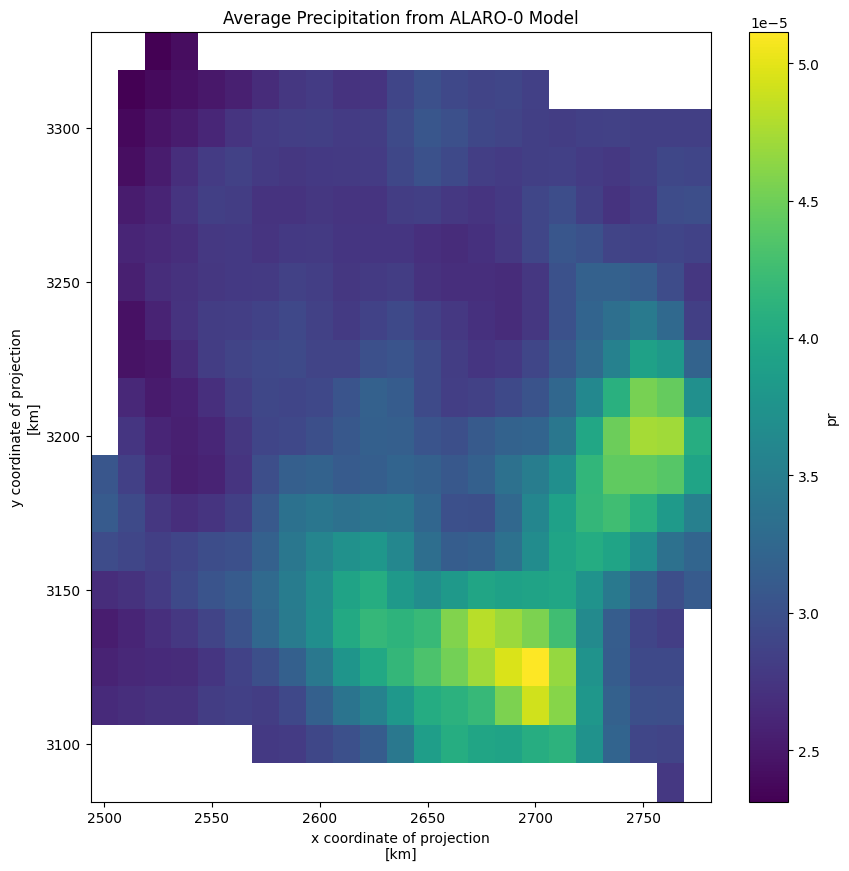

In [14]:
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# Define the geographic bounding box of Belgium
min_lon, min_lat, max_lon, max_lat = 2.5, 49.5, 6.4, 51.5

# Load ALARO-0 model data
model_files = list(Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/ALARO-0_RMIB-UGent/ncdf_GeertLenderink/ERAINT_1980_2010/").rglob("*.nc"))
alaro_ds = xr.open_mfdataset(model_files, chunks="auto")

# Ensure all data are in the same CRS (if needed, but assuming it's already EPSG:4258)
if 'crs' in alaro_ds.attrs:
    print(f"Model CRS: {alaro_ds.attrs['crs']}")

# Subset the ALARO-0 model data to cover Belgium
mask_lon = (alaro_ds.lon >= min_lon) & (alaro_ds.lon <= max_lon)
mask_lat = (alaro_ds.lat >= min_lat) & (alaro_ds.lat <= max_lat)

# Compute the masks before applying them
mask_lon = mask_lon.compute()
mask_lat = mask_lat.compute()

alaro_ds_belgium = alaro_ds.where(mask_lon & mask_lat, drop=True)

# Check the subsetted data
print(f"Subset ALARO-0 model data dimensions: {alaro_ds_belgium.dims}")
print(f"Subset ALARO-0 model data coordinates: {alaro_ds_belgium.coords}")

# Function to plot spatial distribution
def plot_spatial_distribution(data, title, cmap='viridis'):
    plt.figure(figsize=(10, 10))
    data.plot(cmap=cmap)
    plt.title(title)
    plt.show()

# Example plot for average precipitation
plot_spatial_distribution(alaro_ds_belgium['pr'].mean(dim='time'), 'Average Precipitation from ALARO-0 Model')


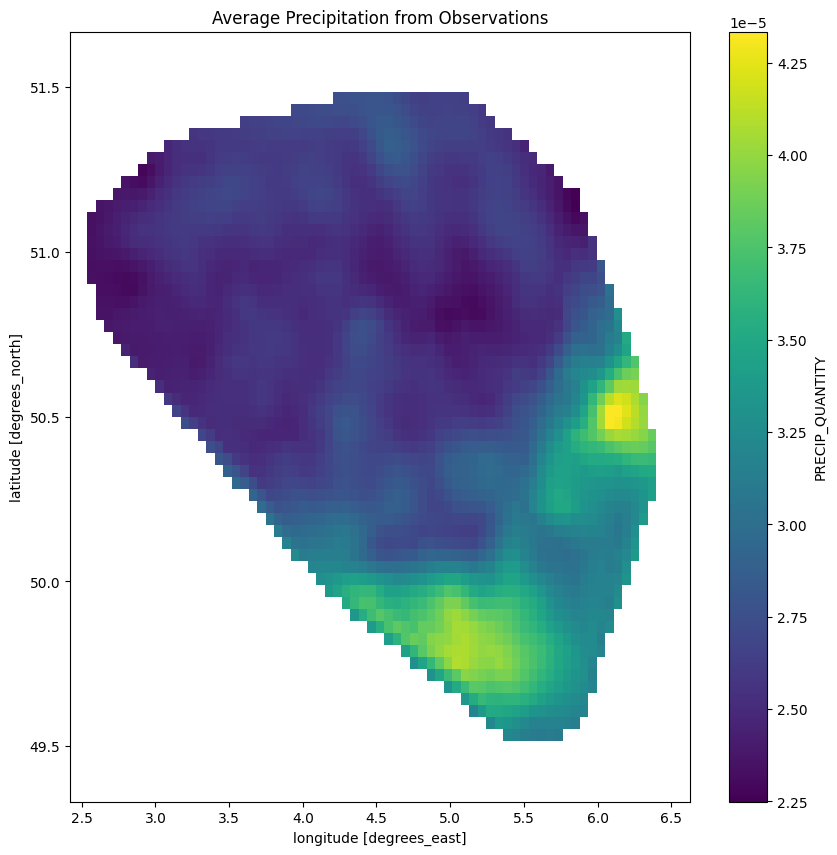

In [15]:
# Function to plot spatial distribution
def plot_spatial_distribution(data, title, cmap='viridis'):
    plt.figure(figsize=(10, 10))
    data.plot(cmap=cmap)
    plt.title(title)
    plt.show()

# Example plot for average precipitation
plot_spatial_distribution(obs_ds['PRECIP_QUANTITY'].mean(dim='time'), 'Average Precipitation from Observations')

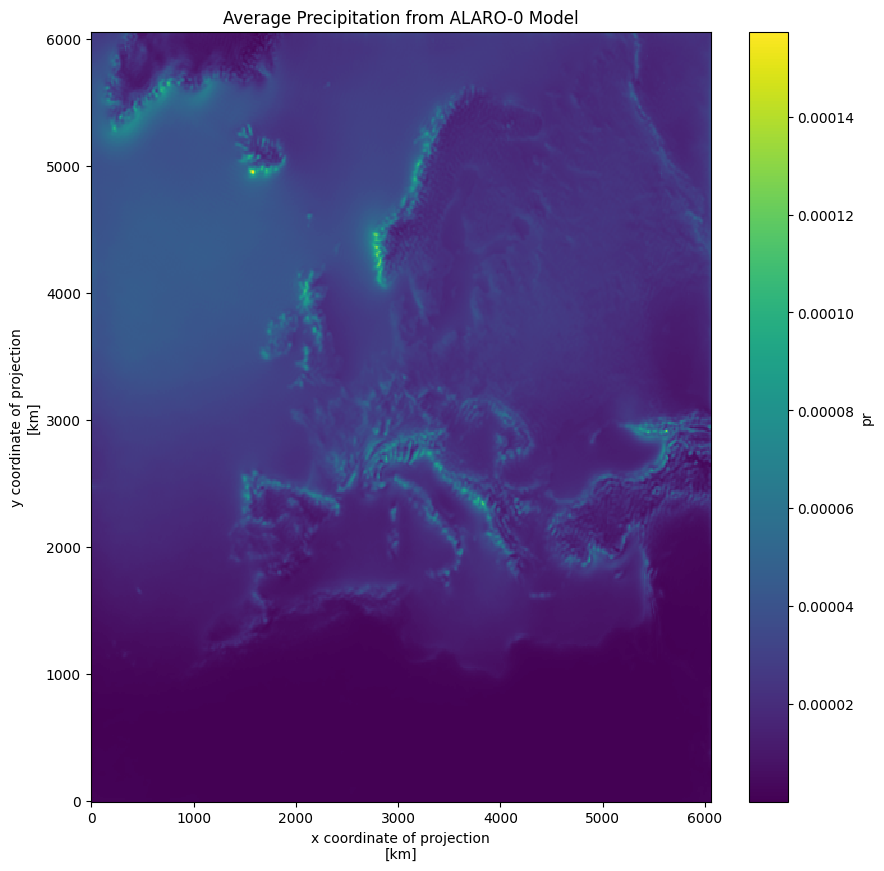

In [22]:
import matplotlib.pyplot as plt

# Plot spatial distribution of precipitation from ALARO-0 model
def plot_spatial_distribution(data, title, cmap='viridis'):
    plt.figure(figsize=(10, 10))
    data.plot(cmap=cmap)
    plt.title(title)
    plt.show()

# Example plot
plot_spatial_distribution(alaro_ds['pr'].mean(dim='time'), 'Average Precipitation from ALARO-0 Model')


## 3. Water Budget Components


# 3.a. Precipitation Analysis
3.a.I. Compare spatial patterns between model and observations:

3.a.II. Compare temporal patterns between model and observations:

In [ ]:
# Function to plot spatial precipitation
def plot_spatial_precipitation(model_data, obs_data, title):
    plt.figure(figsize=(20, 10))

    # Plot model data
    plt.subplot(1, 2, 1)
    model_data.plot(cmap='Blues')
    plt.title(f'{title} - Model')

    # Plot observation data
    plt.subplot(1, 2, 2)
    obs_data.plot(cmap='Blues')
    plt.title(f'{title} - Observations')

    plt.show()

# Example spatial plot for precipitation
model_precip = alaro_ds['pr'].mean(dim='time')
obs_precip = obs_ds['PRECIP_QUANTITY'].mean(dim='time')
plot_spatial_precipitation(model_precip, obs_precip, 'Mean Precipitation')

# Function to plot temporal precipitation
def plot_temporal_precipitation(model_data, obs_data, title):
    plt.figure(figsize=(10, 5))

    model_data.mean(dim=['x', 'y']).plot(label='Model')
    obs_data.mean(dim=['lat', 'lon']).plot(label='Observations')

    plt.title(title)
    plt.legend()
    plt.show()

# Example temporal plot for precipitation
model_precip_time = alaro_ds['pr']
obs_precip_time = obs_ds['PRECIP_QUANTITY']
plot_temporal_precipitation(model_precip_time, obs_precip_time, 'Temporal Mean Precipitation')


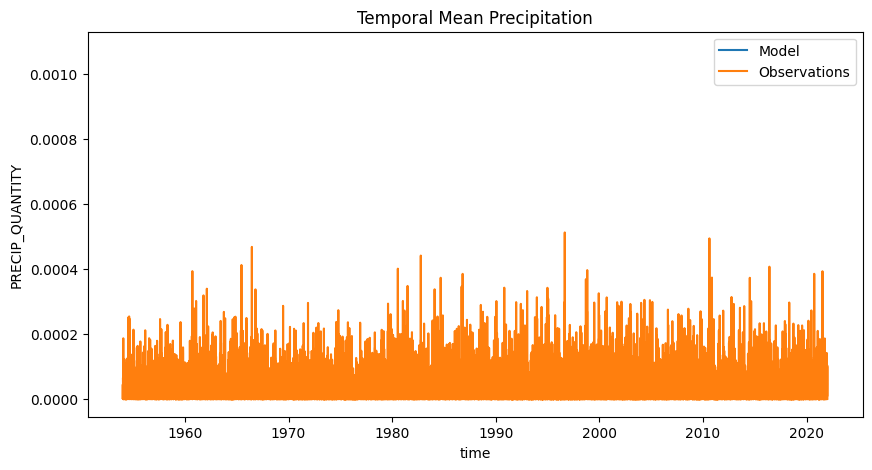

In [16]:
# Function to plot temporal precipitation
def plot_temporal_precipitation(model_data, obs_data, title):
    plt.figure(figsize=(10, 5))

    model_data.mean(dim=['x', 'y']).plot(label='Model')
    obs_data.mean(dim=['lat', 'lon']).plot(label='Observations')

    plt.title(title)
    plt.legend()
    plt.show()

# Example temporal plot for precipitation
model_precip_time = alaro_ds_belgium['pr']
obs_precip_time = obs_ds['PRECIP_QUANTITY']
plot_temporal_precipitation(model_precip_time, obs_precip_time, 'Temporal Mean Precipitation')

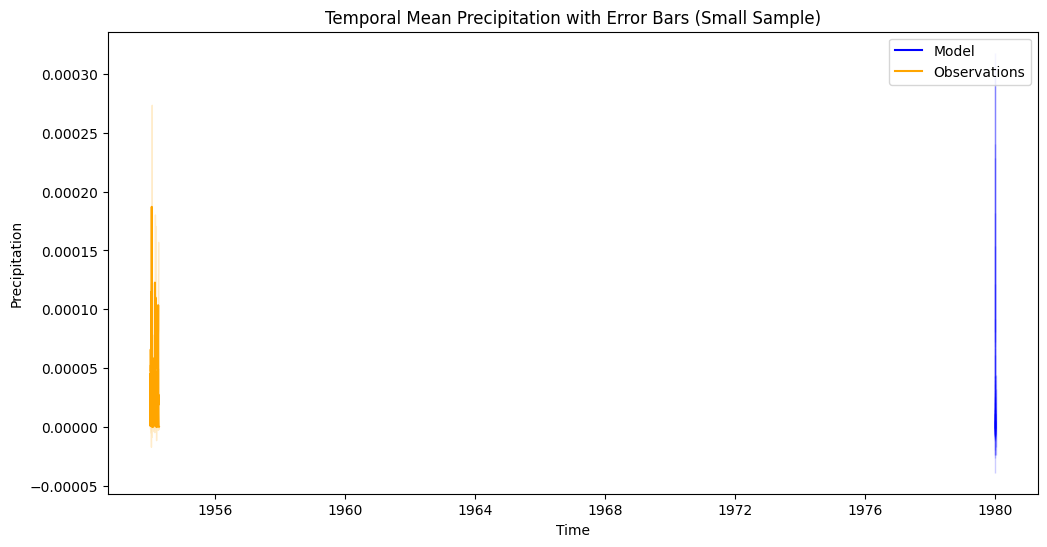

In [18]:
import matplotlib.pyplot as plt
import dask.array as da

# Function to plot temporal precipitation with error bars
def plot_temporal_precipitation_with_error(model_data, obs_data, title):
    plt.figure(figsize=(12, 6))

    # Calculate mean and standard deviation with Dask
    model_mean = model_data.mean(dim=['x', 'y']).compute()
    model_std = model_data.std(dim=['x', 'y']).compute()
    obs_mean = obs_data.mean(dim=['lat', 'lon']).compute()
    obs_std = obs_data.std(dim=['lat', 'lon']).compute()

    plt.plot(model_mean.time, model_mean, label='Model', color='blue')
    plt.fill_between(model_mean.time, model_mean - model_std, model_mean + model_std, color='blue', alpha=0.2)
    
    plt.plot(obs_mean.time, obs_mean, label='Observations', color='orange')
    plt.fill_between(obs_mean.time, obs_mean - obs_std, obs_mean + obs_std, color='orange', alpha=0.2)

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Precipitation')
    plt.legend()
    plt.show()

# Example temporal plot for precipitation with error bars
model_precip_time = alaro_ds_belgium['pr']
obs_precip_time = obs_ds['PRECIP_QUANTITY']

# Reduce dataset size for quicker test
model_precip_time_small = model_precip_time.isel(time=slice(0, 100))
obs_precip_time_small = obs_precip_time.isel(time=slice(0, 100))

plot_temporal_precipitation_with_error(model_precip_time_small, obs_precip_time_small, 'Temporal Mean Precipitation with Error Bars (Small Sample)')



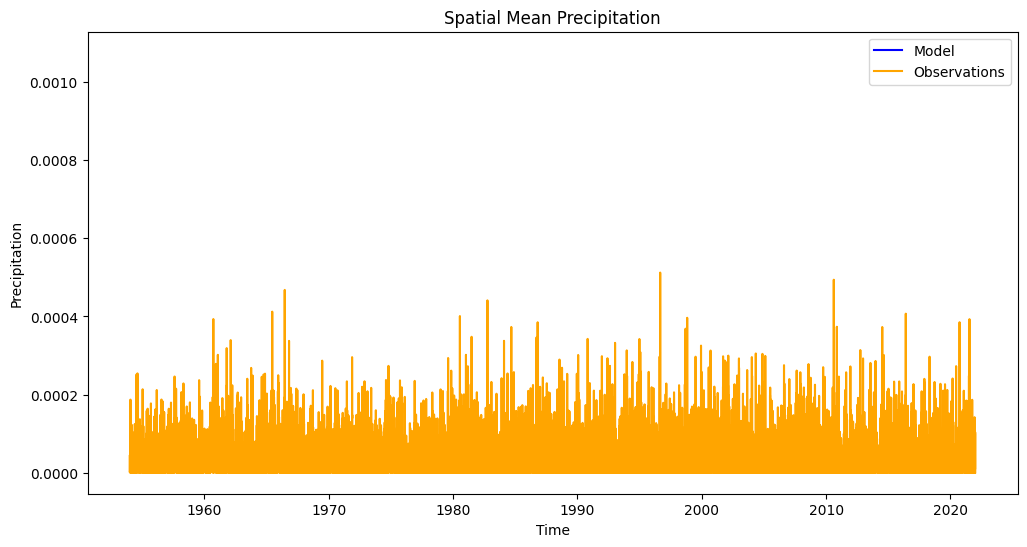

In [6]:
import matplotlib.pyplot as plt

# Function to plot spatial mean precipitation
def plot_spatial_mean_precipitation(model_data, obs_data, title):
    plt.figure(figsize=(12, 6))
    
    # Calculate spatial mean
    model_mean = model_data.mean(dim=['x', 'y'])
    obs_mean = obs_data.mean(dim=['lat', 'lon'])

    plt.plot(model_mean.time, model_mean, label='Model', color='blue')
    plt.plot(obs_mean.time, obs_mean, label='Observations', color='orange')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Precipitation')
    plt.legend()
    plt.show()

# Example plot for spatial mean precipitation
model_precip_time = alaro_ds_belgium['pr']
obs_precip_time = obs_ds['PRECIP_QUANTITY']
plot_spatial_mean_precipitation(model_precip_time, obs_precip_time, 'Spatial Mean Precipitation')



In [1]:
def plot_scatter_with_equality_line(model_data, obs_data, title):
    plt.figure(figsize=(8, 8))
    
    plt.scatter(obs_data.values.flatten(), model_data.values.flatten(), alpha=0.5, label='Data points')
    plt.plot([obs_data.min(), obs_data.max()], [obs_data.min(), obs_data.max()], color='red', linestyle='--', label='Line of Equality')
    
    plt.xlabel('Observations')
    plt.ylabel('Model')
    plt.title(title)
    plt.legend()
    plt.show()

# Example scatter plot
plot_scatter_with_equality_line(model_precip_time.mean(dim=['x', 'y']), obs_precip_time.mean(dim=['lat', 'lon']), 'Scatter Plot of Precipitation')


NameError: name 'model_precip_time' is not defined

ValueError: x and y must be the same size

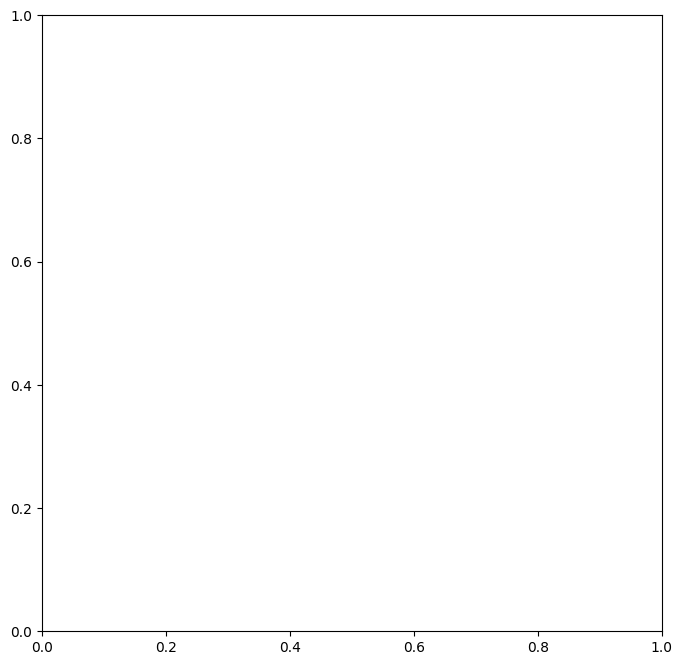

In [7]:
# Ensure the data variables are consistent
model_precip_time = alaro_ds_belgium['pr']
obs_precip_time = obs_ds['PRECIP_QUANTITY']

# Function to plot scatter plot with equality line
def plot_scatter_with_equality_line(model_data, obs_data, title):
    plt.figure(figsize=(8, 8))
    
    plt.scatter(obs_data.values.flatten(), model_data.values.flatten(), alpha=0.5, label='Data points')
    plt.plot([obs_data.min(), obs_data.max()], [obs_data.min(), obs_data.max()], color='red', linestyle='--', label='Line of Equality')
    
    plt.xlabel('Observations')
    plt.ylabel('Model')
    plt.title(title)
    plt.legend()
    plt.show()

# Example scatter plot
plot_scatter_with_equality_line(model_precip_time.mean(dim=['time']), obs_precip_time.mean(dim=['time']), 'Scatter Plot of Precipitation')

In [ ]:
def plot_distributions(model_data, obs_data, title):
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(model_data.values.flatten(), label='Model', color='blue')
    sns.kdeplot(obs_data.values.flatten(), label='Observations', color='orange')
    
    plt.title(title)
    plt.xlabel('Precipitation')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Example distribution plot
plot_distributions(model_precip_time, obs_precip_time, 'Distribution of Precipitation')


In [ ]:
def plot_bias_rmse_over_time(model_data, obs_data, title):
    plt.figure(figsize=(12, 6))

    bias = (model_data - obs_data).mean(dim=['x', 'y'])
    rmse = np.sqrt(((model_data - obs_data) ** 2).mean(dim=['x', 'y']))
    
    bias.plot(label='Bias', color='red')
    rmse.plot(label='RMSE', color='blue')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example bias and RMSE plot
plot_bias_rmse_over_time(model_precip_time, obs_precip_time, 'Bias and RMSE of Precipitation over Time')


# 3.b. Evaporation Analysis
Since I don't have direct evaporation data, you can use temperature as a proxy. Generally, higher temperatures indicate higher potential evaporation.

In [ ]:
# Function to plot spatial temperature
def plot_spatial_temperature(model_data, obs_data, title):
    plt.figure(figsize=(20, 10))

    # Plot model data
    plt.subplot(1, 2, 1)
    model_data.plot(cmap='Reds')
    plt.title(f'{title} - Model')

    # Plot observation data
    plt.subplot(1, 2, 2)
    obs_data.plot(cmap='Reds')
    plt.title(f'{title} - Observations')

    plt.show()

# Example spatial plot for temperature
model_temp = alaro_ds['tas'].mean(dim='time')
obs_temp = obs_ds['TEMP_AVG'].mean(dim='time')
plot_spatial_temperature(model_temp, obs_temp, 'Mean Temperature')

# Function to plot temporal temperature
def plot_temporal_temperature(model_data, obs_data, title):
    plt.figure(figsize=(10, 5))

    model_data.mean(dim=['x', 'y']).plot(label='Model')
    obs_data.mean(dim=['lat', 'lon']).plot(label='Observations')

    plt.title(title)
    plt.legend()
    plt.show()

# Example temporal plot for temperature
model_temp_time = alaro_ds['tas']
obs_temp_time = obs_ds['TEMP_AVG']
plot_temporal_temperature(model_temp_time, obs_temp_time, 'Temporal Mean Temperature')


# 3.c. Runoff Analysis
Runoff is typically derived from precipitation and other hydrological processes. For now, I focus on the precipitation as a proxy.

# 3.d. Balance Analysis
This analysis involves understanding the distribution and changes over time and space.

In [ ]:
# Balance Analysis: Precipitation and Temperature
def plot_balance_analysis(model_precip, model_temp, obs_precip, obs_temp):
    plt.figure(figsize=(20, 10))

    # Precipitation balance
    plt.subplot(2, 2, 1)
    model_precip.plot(cmap='Blues')
    plt.title('Model Precipitation')

    plt.subplot(2, 2, 2)
    obs_precip.plot(cmap='Blues')
    plt.title('Observed Precipitation')

    # Temperature balance
    plt.subplot(2, 2, 3)
    model_temp.plot(cmap='Reds')
    plt.title('Model Temperature')

    plt.subplot(2, 2, 4)
    obs_temp.plot(cmap='Reds')
    plt.title('Observed Temperature')

    plt.show()

# Example balance analysis plot
plot_balance_analysis(model_precip, model_temp, obs_precip, obs_temp)


## 4. Statistical Evaluation


In [ ]:
import xarray as xr
import geopandas as gpd
import rioxarray  # Ensure you import rioxarray
from pathlib import Path
import matplotlib.pyplot as plt
from xesmf import Regridder
import numpy as np
from sklearn.metrics import mean_absolute_error

# Regrid observational data to match model data grid
regridder = Regridder(obs_ds, alaro_ds, method='bilinear')
obs_regridded = regridder(obs_ds)

# Statistical metrics calculation function
def compute_statistics(model, obs):
    bias = np.mean(model - obs)
    rmse = np.sqrt(np.mean((model - obs) ** 2))
    correlation = np.corrcoef(model.flatten(), obs.flatten())[0, 1]
    mae = mean_absolute_error(obs.flatten(), model.flatten())
    std_model = np.std(model)
    std_obs = np.std(obs)
    return bias, rmse, correlation, mae, std_model, std_obs

# Compute statistics for precipitation
model_precip = alaro_ds['pr'].mean(dim='time').values
obs_precip = obs_regridded['PRECIP_QUANTITY'].mean(dim='time').values

bias, rmse, correlation, mae, std_model, std_obs = compute_statistics(model_precip, obs_precip)
print(f"Bias: {bias}, RMSE: {rmse}, Correlation: {correlation}, MAE: {mae}, Model STD: {std_model}, Observed STD: {std_obs}")

# Function to plot spatial maps of statistical metrics
def plot_spatial_metric(metric, title, belgium_gdf, dem, cmap='viridis'):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    metric.plot(ax=ax, cmap=cmap)
    belgium_gdf.boundary.plot(ax=ax, edgecolor='black')
    dem.plot(ax=ax, cmap='terrain', alpha=0.5)  # Overlay DEM
    plt.title(title)
    plt.show()

# Compute and plot spatial bias
bias_map = alaro_ds['pr'].mean(dim='time') - obs_regridded['PRECIP_QUANTITY'].mean(dim='time')
plot_spatial_metric(bias_map, 'Spatial Bias of Precipitation', belgium_gdf, dem, cmap='coolwarm')

# Compute and plot spatial RMSE
rmse_map = np.sqrt((alaro_ds['pr'].mean(dim='time') - obs_regridded['PRECIP_QUANTITY'].mean(dim='time')) ** 2)
plot_spatial_metric(rmse_map, 'Spatial RMSE of Precipitation', belgium_gdf, dem, cmap='viridis')

# Function to plot Taylor diagram
def plot_taylor_diagram(std_obs, std_model, correlation):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Taylor diagram
    theta = np.arccos(correlation)
    r = std_model / std_obs
    
    ax.plot([0, theta], [0, r], 'b-')  # Model point
    ax.plot([0, 0], [0, 1], 'k--')  # Reference point
    
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Standard Deviation')
    
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    ax.set_ylim(0, max(1, r) + 0.5)
    
    ax.grid(True)
    plt.title('Taylor Diagram')
    plt.show()

# Plot Taylor diagram for precipitation
plot_taylor_diagram(std_obs, std_model, correlation)

# Seasonal analysis
def compute_seasonal_statistics(model, obs, season):
    model_season = model.sel(time=model['time.season'] == season).mean(dim='time').values
    obs_season = obs.sel(time=obs['time.season'] == season).mean(dim='time').values
    return compute_statistics(model_season, obs_season)

seasons = ['DJF', 'MAM', 'JJA', 'SON']
seasonal_stats = {season: compute_seasonal_statistics(alaro_ds['pr'], obs_regridded['PRECIP_QUANTITY'], season) for season in seasons}

for season, stats in seasonal_stats.items():
    bias, rmse, correlation, mae, std_model, std_obs = stats
    print(f"Season: {season}, Bias: {bias}, RMSE: {rmse}, Correlation: {correlation}, MAE: {mae}, Model STD: {std_model}, Observed STD: {std_obs}")



## 5. Temporal Analysis


In [ ]:
# Plot time series of precipitation
def plot_time_series(data, title):
    plt.figure(figsize=(15, 5))
    data.plot()
    plt.title(title)
    plt.show()

plot_time_series(alaro_ds['pr'].mean(dim=['x', 'y']), 'Time Series of Mean Precipitation (ALARO-0)')


In [ ]:
import pandas as pd
import seaborn as sns

# Function to plot time series
def plot_time_series(data, var_name, title):
    plt.figure(figsize=(15, 5))
    data[var_name].groupby('time').mean(dim=['y', 'x']).plot()
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(var_name)
    plt.grid(True)
    plt.show()

# Example time series plot for precipitation
plot_time_series(alaro_ds, 'pr', 'Time Series of Precipitation from ALARO-0 Model')

# Function to plot seasonal cycle
def plot_seasonal_cycle(data, var_name, title):
    plt.figure(figsize=(10, 5))
    data['month'] = data['time.month']
    monthly_data = data.groupby('month').mean(dim=['time', 'y', 'x'])
    monthly_data[var_name].plot()
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel(var_name)
    plt.grid(True)
    plt.show()

# Example seasonal cycle plot for precipitation
plot_seasonal_cycle(alaro_ds, 'pr', 'Seasonal Cycle of Precipitation from ALARO-0 Model')

# Function to compute and plot anomalies
def plot_anomalies(data, var_name, title):
    clim = data.groupby('time.month').mean(dim='time')
    anomalies = data.groupby('time.month') - clim
    plt.figure(figsize=(15, 5))
    anomalies[var_name].groupby('time').mean(dim=['y', 'x']).plot()
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(f'{var_name} Anomaly')
    plt.grid(True)
    plt.show()

# Example anomalies plot for precipitation
plot_anomalies(alaro_ds, 'pr', 'Precipitation Anomalies from ALARO-0 Model')

# Function to compute and plot trends over time
def plot_trend(data, var_name, title):
    times = pd.to_datetime(data['time'].values)
    data_series = data[var_name].mean(dim=['y', 'x']).values
    trend = np.polyfit(times.astype(float), data_series, 1)
    trendline = np.polyval(trend, times.astype(float))

    plt.figure(figsize=(15, 5))
    plt.plot(times, data_series, label='Data')
    plt.plot(times, trendline, label=f'Trend (slope={trend[0]:.2e})', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(var_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example trend plot for precipitation
plot_trend(alaro_ds, 'pr', 'Trend of Precipitation from ALARO-0 Model')

# Compare temporal evolution of model and observations
def compare_temporal_evolution(model, obs, var_name, title):
    model_series = model[var_name].groupby('time').mean(dim=['y', 'x'])
    obs_series = obs[var_name].groupby('time').mean(dim=['lat', 'lon'])
    plt.figure(figsize=(15, 5))
    model_series.plot(label='Model')
    obs_series.plot(label='Observations')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(var_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Regrid observational data to match model data grid
regridder = Regridder(obs_ds, alaro_ds, method='bilinear')
obs_regridded = regridder(obs_ds)

# Compare temporal evolution for precipitation
compare_temporal_evolution(alaro_ds, obs_regridded, 'pr', 'Temporal Evolution of Precipitation: Model vs Observations')

# Seasonal analysis
def plot_seasonal_variability(data, var_name, title):
    data_seasonal = data[var_name].groupby('time.season').mean(dim=['time', 'y', 'x'])
    data_seasonal.plot(kind='bar', figsize=(10, 5))
    plt.title(title)
    plt.xlabel('Season')
    plt.ylabel(var_name)
    plt.grid(True)
    plt.show()

# Example seasonal variability plot for precipitation
plot_seasonal_variability(alaro_ds, 'pr', 'Seasonal Variability of Precipitation from ALARO-0 Model')


## 6. Extreme Events Analysis


In [ ]:
# Identify and analyze extreme precipitation events
def identify_extreme_events(data, threshold):
    extreme_events = data.where(data > threshold, drop=True)
    return extreme_events

extreme_precip = identify_extreme_events(alaro_ds['pr'], threshold=50)
plot_time_series(extreme_precip.mean(dim=['x', 'y']), 'Extreme Precipitation Events (ALARO-0)')


## 7. Visualization and Presentation


In [ ]:
# Example 3D plot integrating topography
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_topography(data, topography, title):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    x = data['x'].values
    y = data['y'].values
    X, Y = np.meshgrid(x, y)
    Z = topography.values
    ax.plot_surface(X, Y, Z, cmap='terrain')
    plt.title(title)
    plt.show()

# Assuming 'topography' is a variable in your DEM dataset
plot_3d_topography(alaro_ds, alaro_ds['topography'], '3D Topography of Belgium')


3D plot integrating topography

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_topography(data, dem, title):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    x = data['x'].values
    y = data['y'].values
    X, Y = np.meshgrid(x, y)
    Z = dem.isel(band=0).values  # Assuming DEM has a 'band' dimension
    ax.plot_surface(X, Y, Z, cmap='terrain')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    ax.set_zlabel('Elevation (m)')
    plt.show()

# Plotting 3D topography
plot_3d_topography(alaro_ds, dem, '3D Topography of Belgium')


Enhanced Visualizations

Function to plot spatial distribution with topography and borders

In [ ]:
def plot_spatial_distribution_with_context(data, title, belgium_gdf, dem, cmap='viridis'):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    data.plot(ax=ax, cmap=cmap)
    belgium_gdf.boundary.plot(ax=ax, edgecolor='black')
    dem.plot(ax=ax, cmap='terrain', alpha=0.5)  # Overlay DEM
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Example plot for precipitation
plot_spatial_distribution_with_context(alaro_ds['pr'].mean(dim='time'), 'Average Precipitation from ALARO-0 Model', belgium_gdf, dem)


Function to plot temporal trends with enhanced context

In [ ]:
def plot_temporal_trend_with_context(data, var_name, title, belgium_gdf, dem):
    plt.figure(figsize=(15, 5))
    ax = plt.gca()
    data[var_name].groupby('time').mean(dim=['y', 'x']).plot(ax=ax)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(var_name)
    plt.grid(True)
    plt.show()

    # Plot spatial distribution for a selected time to provide context
    selected_time = data['time'].isel(time=0).values  # Change index to select different times
    plot_spatial_distribution_with_context(data.sel(time=selected_time)[var_name], f'{title} at {selected_time}', belgium_gdf, dem)

# Example plot for temporal trend of precipitation
plot_temporal_trend_with_context(alaro_ds, 'pr', 'Temporal Trend of Precipitation from ALARO-0 Model', belgium_gdf, dem)


## 8. Conclusion

### Summary of Findings
- Summarize key findings from the spatial, temporal, and statistical analyses.

### Model Performance
- Discuss the strengths and weaknesses of the ALARO-0 model in simulating the water cycle.

### Recommendations
- Provide recommendations for future improvements and potential areas of further research.


## Load in the CORDEX.be I data


In [3]:
import valenspy.cf_checks
print(dir(valenspy.cf_checks))


['CORDEX_VARIABLES', 'List', 'MAIN_METADATA', 'Path', 'Union', 'VARIABLE_METADATA', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_check_file_extension', '_check_main_metadata', '_check_variable_by_name', '_check_variable_metadata', 'file', 'files', 'is_cf_compliant', 'safe_load', 'xr']


In [6]:
import valenspy
valenspy.__file__


'/mnt/HDS_CORDEXBE_RMIB/kvandela/ValEnsPy/src/valenspy/__init__.py'

In [3]:
files= list(Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/ALARO-0_RMIB-UGent/ncdf_GeertLenderink/ERAINT_1980_2010/").rglob("*.nc"))
alaro_ds = xr.open_mfdataset(files, chunks="auto")
alaro_ds

<xarray.Dataset> Size: 2TB
Dimensions:            (x: 485, y: 485, time: 543504, bnds: 2)
Coordinates:
  * x                  (x) float64 4kB 0.0 12.5 25.0 ... 6.038e+03 6.05e+03
  * y                  (y) float64 4kB 0.0 12.5 25.0 ... 6.038e+03 6.05e+03
  * time               (time) datetime64[ns] 4MB 1980-01-01 ... 2010-12-31T23...
    lon                (y, x) float64 2MB dask.array<chunksize=(485, 485), meta=np.ndarray>
    lat                (y, x) float64 2MB dask.array<chunksize=(485, 485), meta=np.ndarray>
    height             float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    huss               (time, y, x) float32 511GB dask.array<chunksize=(284, 485, 485), meta=np.ndarray>
    Lambert_Conformal  (time) object 4MB b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    pr                 (time, y, x) float32 511GB dask.array<chunksize=(285, 485, 485), meta=np.ndarray>
    time_bnds          (time, bnds) datetime64[ns] 9MB dask.array<chunksize=(17569, 2), meta=np.ndarray>
    ps                 (time, y, x) float32 511GB dask.array<chunksize=(284, 485, 485), meta=np.ndarray>
    tas                (time, y, x) float32 511GB dask.array<chunksize=(284, 485, 485), meta=np.ndarray>
Attributes: (12/24)
    institute_id:                   RMIB-UGent
    model_id:                       RMIB-UGent-ALARO-0
    experiment_id:                  evaluation
    product:                        output
    Conventions:                    CF-1.6
    driving_model_id:               ECMWF-ERAINT
    ...                             ...
    endtime:                        347151600.0
    frequency:                      1hr
    creation_date:                  2019-01-30T21:07:50Z
    tracking_id:                    fce1ee51-5cab-4ff6-8bc5-ffca160ea1c3
    driving_experiment:             ECMWF-ERAINT, evaluation, r1i1p1
    history:                        Created by CordextractR v1.9-84-g0054a8f

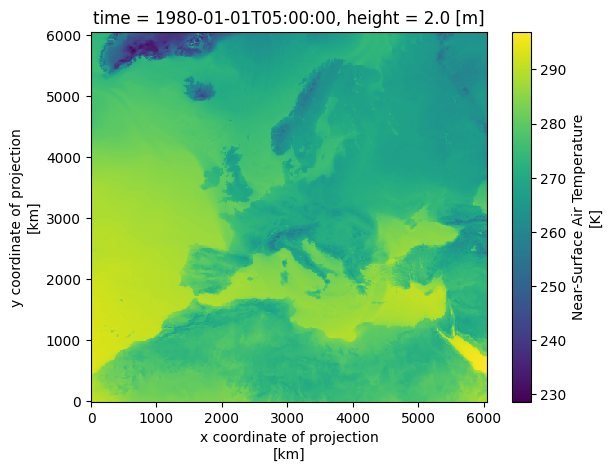

In [4]:
alaro_ds.tas.isel(time=10).plot()

# Load in the Observational data

In [5]:
ds = xr.open_mfdataset("/mnt/HDS_FORESTFLOW/FORESTFLOW/CLIMATE_GRID/SYLVAIN/Daily*.nc", chunks="auto")
ds

<xarray.Dataset> Size: 4GB
Dimensions:          (time: 24837, lat: 64, lon: 73)
Coordinates:
  * lon              (lon) float64 584B 2.45 2.508 2.565 ... 6.485 6.542 6.6
  * lat              (lat) float64 512B 49.35 49.39 49.42 ... 51.58 51.61 51.65
  * time             (time) datetime64[ns] 199kB 1954-01-01 ... 2021-12-31
Data variables:
    PRECIP_QUANTITY  (time, lat, lon) float64 928MB dask.array<chunksize=(365, 64, 73), meta=np.ndarray>
    TEMP_AVG         (time, lat, lon) float64 928MB dask.array<chunksize=(365, 64, 73), meta=np.ndarray>
    TEMP_MAX         (time, lat, lon) float64 928MB dask.array<chunksize=(365, 64, 73), meta=np.ndarray>
    TEMP_MIN         (time, lat, lon) float64 928MB dask.array<chunksize=(365, 64, 73), meta=np.ndarray>
Attributes:
    Creators:                     Ghilain N., Van Schaeybroeck B., Marchi S.
    Version:                      1.1
    Affiliation:                  Royal Meteorological Institute of Belgium
    Url:                          https://opendata.meteo.be/geonetwork/srv/en...
    Coordinate reference system:  EPSG:4258
    Identifier:                   RMI_DATASET_GRIDDEDOBS

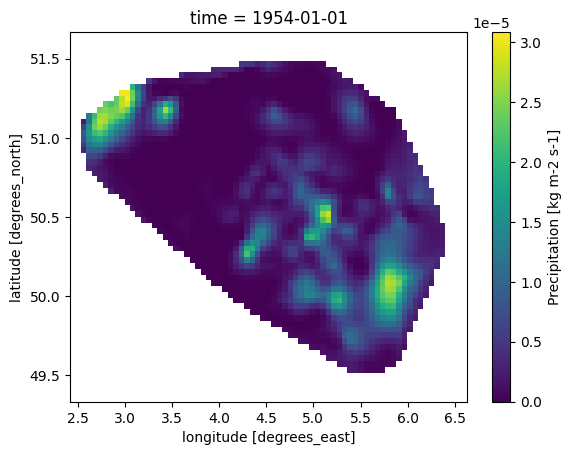

In [6]:
#plot the first time step for Precipitation
ds.PRECIP_QUANTITY.isel(time=0).plot()

## CF Checker

## What is checked?

In Valenspy, the self implemented CF conventions checker checks the following:

- The global attributes `history` and `Conventions` are present.
- Per variable the attributes `standard_name`, `long_name` & `units` are present.
- Checks if the file is a netCDF file.

In addition the cf_checker compares the variables in the file with the CORDEX_variables.yml file. 
If the variable is in the CORDEX_variables.yml file, the checker will check if the variable has the correct attributes.

In [2]:
# Perform CF compliance check on the model dataset
model_cf_compliant = vp.cf_checks.is_cf_compliant(alaro_ds)

# Perform CF compliance check on the observational dataset
obs_cf_compliant = vp.cf_checks.is_cf_compliant(ds)
print(model_cf_compliant)
print(obs_cf_compliant)

NameError: name 'alaro_ds' is not defined

In [5]:
cf_status(alaro_ds) 
cf_status(ds) # A path or a dataset can be passed - here we pass the dataset

NameError: name 'cf_status' is not defined

## Temporal Analysis

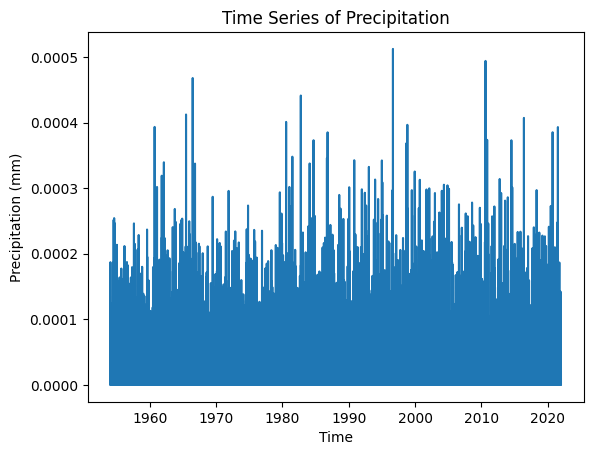

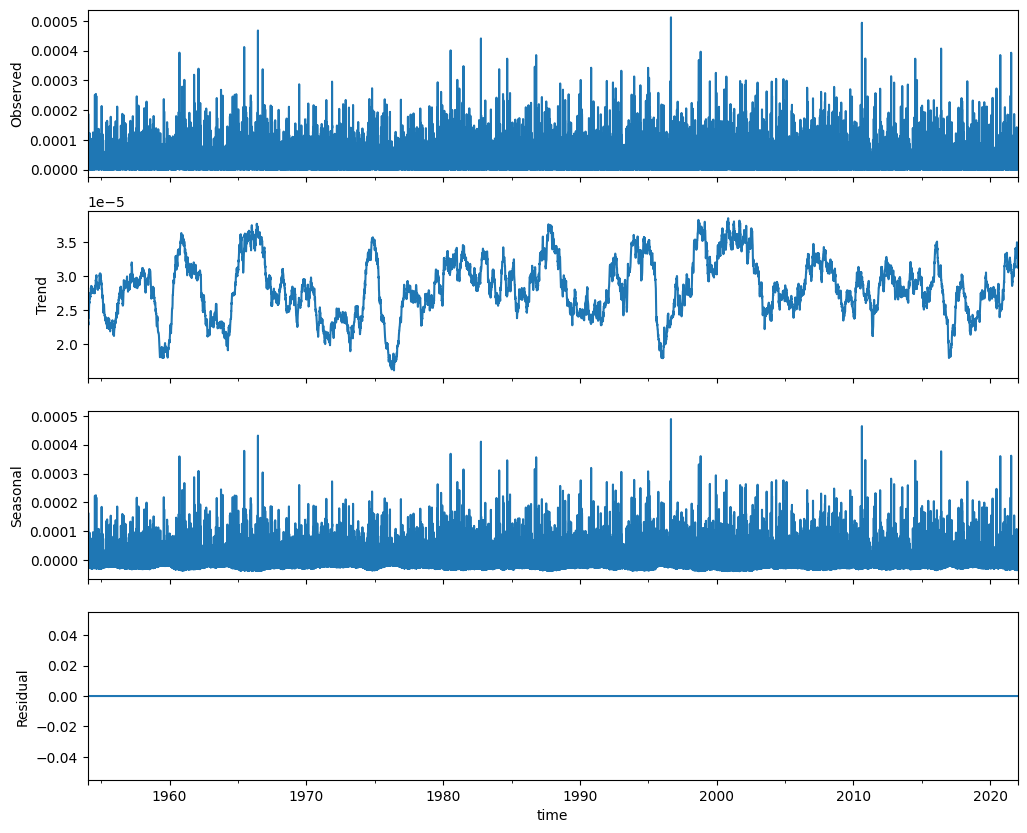

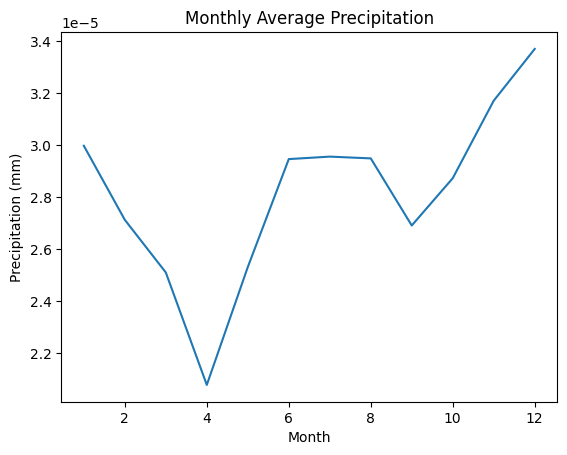

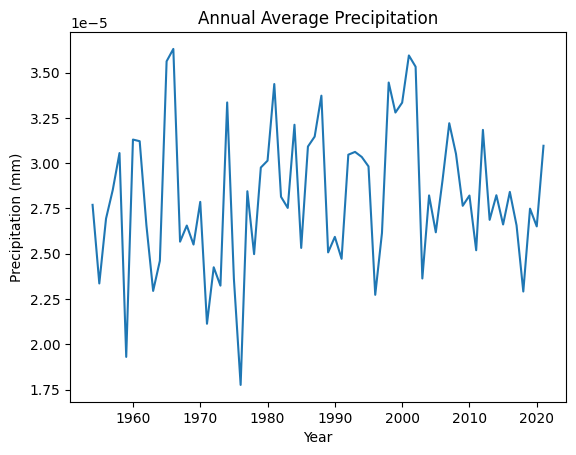

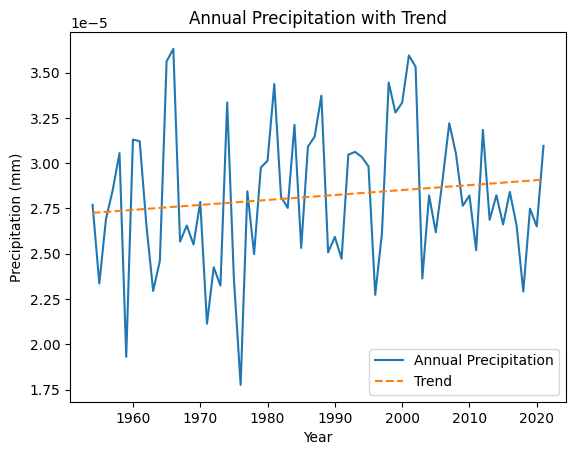

In [110]:
# Imports
from pathlib import Path
from datatree import DataTree
import dask
import xarray as xr
import pandas as pd
import valenspy as vp
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean over lat and lon
precip_ts = ds.PRECIP_QUANTITY.mean(dim=['lat', 'lon'])

# Trigger computation explicitly
precip_ts = precip_ts.compute()

# Plot the time series of precipitation
precip_ts.plot()
plt.title('Time Series of Precipitation')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.show()

# Convert to pandas Series
precip_ts_pd = precip_ts.to_series()

# Perform seasonal decomposition using pandas
decomposition = precip_ts_pd.resample('D').mean().dropna().interpolate()

# Decompose the time series
decomposed = decomposition.to_frame(name='precipitation')
decomposed['trend'] = decomposed['precipitation'].rolling(window=365, center=True, min_periods=120).mean()
decomposed['seasonal'] = decomposed['precipitation'] - decomposed['precipitation'].rolling(window=365, center=True, min_periods=120).mean()
decomposed['residual'] = decomposed['precipitation'] - decomposed['trend'] - decomposed['seasonal']

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposed['precipitation'].plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposed['trend'].plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposed['seasonal'].plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposed['residual'].plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.show()

# Monthly and annual average precipitation
precip_monthly = precip_ts.groupby('time.month').mean()
precip_monthly.plot()
plt.title('Monthly Average Precipitation')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.show()

precip_annual = precip_ts.groupby('time.year').mean()
precip_annual.plot()
plt.title('Annual Average Precipitation')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.show()

# Trend analysis
trend_precip = precip_annual.polyfit(dim='year', deg=1)
trend_precip_poly = xr.polyval(precip_annual['year'], trend_precip.polyfit_coefficients)
precip_annual.plot(label='Annual Precipitation')
trend_precip_poly.plot(label='Trend', linestyle='--')
plt.legend()
plt.title('Annual Precipitation with Trend')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.show()



## Spatial Analysis

## Extreme Events Analysis


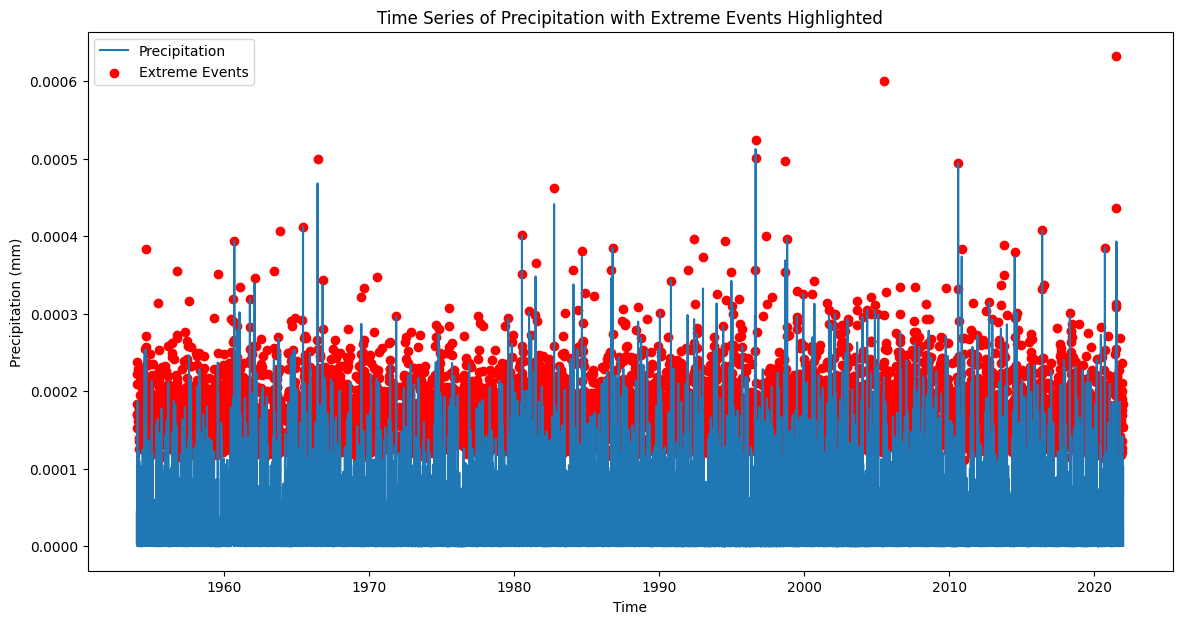

In [111]:
# Rechunk the data along the time dimension
ds_rechunked = ds.PRECIP_QUANTITY.chunk({'time': -1})

# Compute the 95th percentile for each grid point
quantile_95 = ds_rechunked.quantile(0.95, dim='time')

# Identify extreme events
extreme_events = ds_rechunked.where(ds_rechunked > quantile_95)

# Convert extreme events to a pandas DataFrame
extreme_events_ts = extreme_events.mean(dim=['lat', 'lon']).to_series()

# Plot the time series of precipitation with extreme events highlighted
plt.figure(figsize=(14, 7))
plt.plot(precip_ts_pd.index, precip_ts_pd, label='Precipitation')
plt.scatter(extreme_events_ts.index, extreme_events_ts, color='red', label='Extreme Events', marker='o')
plt.title('Time Series of Precipitation with Extreme Events Highlighted')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

In [ ]:
# Compute the return period for extreme events
quantile_95 = ds.PRECIP_QUANTITY.chunk({'time': -1}).quantile(0.95, dim='time')
extreme_counts = ds.PRECIP_QUANTITY.where(ds.PRECIP_QUANTITY > quantile_95).count(dim='time')
return_periods = (len(ds.time) / extreme_counts).where(extreme_counts > 0)

return_periods.plot()
plt.title('Return Periods of Extreme Precipitation Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
# Compute consecutive rainy days
rainy_days = (ds.PRECIP_QUANTITY > 0).astype(int)
consecutive_rainy_days = rainy_days.rolling(time=7, min_periods=1).sum()

# Plot consecutive rainy days for a specific time step
time_step = 0  # Choose a specific time step to visualize
plt.figure(figsize=(10, 8))
consecutive_rainy_days.isel(time=time_step).plot(cmap='Blues')
plt.title(f'Consecutive Rainy Days at Time Step {time_step}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
# Define a threshold for drought (e.g., below 5th percentile of precipitation)
drought_threshold = ds.PRECIP_QUANTITY.chunk({'time': -1}).quantile(0.05, dim='time')

# Identify drought events
drought_events = ds.PRECIP_QUANTITY.where(ds.PRECIP_QUANTITY < drought_threshold)

# Compute consecutive dry days
dry_days = (ds.PRECIP_QUANTITY < drought_threshold).astype(int)
consecutive_dry_days = dry_days.rolling(time=7, min_periods=1).sum()

# Plot drought events and consecutive dry days for a specific time step
time_step = 0  # Choose a specific time step to visualize
plt.figure(figsize=(10, 8))
drought_events.isel(time=time_step).plot(cmap='Reds')
plt.title(f'Drought Events at Time Step {time_step}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

plt.figure(figsize=(10, 8))
consecutive_dry_days.isel(time=time_step).plot(cmap='Reds')
plt.title(f'Consecutive Dry Days at Time Step {time_step}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Statistics

In [ ]:
# Rechunk the data along the time dimension
ds_rechunked = ds.PRECIP_QUANTITY.chunk({'time': -1})

# Compute the mean and standard deviation of precipitation over time
precip_mean = ds_rechunked.mean(dim='time')
precip_std = ds_rechunked.std(dim='time')

# Compute anomalies (deviation from mean)
precip_anomaly = ds_rechunked - precip_mean

# Plot the mean precipitation spatially
plt.figure(figsize=(10, 8))
precip_mean.plot(cmap='Blues')
plt.title('Mean Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot the standard deviation of precipitation spatially
plt.figure(figsize=(10, 8))
precip_std.plot(cmap='Reds')
plt.title('Standard Deviation of Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot the anomalies for a specific time step
time_step = 0  # Choose a specific time step to visualize
plt.figure(figsize=(10, 8))
precip_anomaly.isel(time=time_step).plot(cmap='RdBu', center=0)
plt.title(f'Precipitation Anomalies at Time Step {time_step}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



In [ ]:
from scipy.stats import pearsonr
import numpy as np

# Ensure data alignment for statistical metrics calculation
model_temp = alaro_ds.tas.mean(dim=['y', 'x'])
obs_temp = ds.TEMP_AVG.mean(dim=['lat', 'lon'])

# Compute bias, RMSE, and correlation coefficient
bias = np.mean(model_temp - obs_temp)
rmse = np.sqrt(np.mean((model_temp - obs_temp)**2))
correlation, _ = pearsonr(model_temp.values.flatten(), obs_temp.values.flatten())

print(f'Bias: {bias}')
print(f'RMSE: {rmse}')
print(f'Correlation: {correlation}')

# Taylor diagram function
def taylor_diagram(stddev, correlation, ax):
    ax.plot(correlation * stddev, stddev, 'o', markersize=10)
    ax.annotate(f"Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nCorr: {correlation:.2f}", 
                (correlation * stddev, stddev), textcoords="offset points", xytext=(10,-10), ha='center')

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
taylor_diagram(np.std(model_temp), correlation, ax)
plt.show()


## Water Budget Components

In [ ]:
# Compute the components of the water budget
precip = alaro_ds.pr
evaporation = alaro_ds.evspsbl
runoff = alaro_ds.mrro

# Calculate the water budget (precipitation - evaporation - runoff)
water_budget = precip - evaporation - runoff

# Plot the water budget components
plt.figure(figsize=(12, 6))
precip.isel(time=0).plot(label='Precipitation')
evaporation.isel(time=0).plot(label='Evaporation')
runoff.isel(time=0).plot(label='Runoff')
water_budget.isel(time=0).plot(label='Water Budget', linestyle='--')
plt.legend()
plt.title('Water Budget Components (First Time Step)')
plt.show()

# Analyze the balance and changes over time and space
water_budget_mean = water_budget.mean(dim=['x', 'y'])
water_budget_mean.plot()
plt.title('Mean Water Budget Over Time')
plt.show()


# Subset: temporal

In [ ]:
import xarray as xr
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
model_files = list(Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/ALARO-0_RMIB-UGent/ncdf_GeertLenderink/ERAINT_1980_2010/").rglob("*.nc"))
alaro_ds = xr.open_mfdataset(model_files, chunks="auto")

obs_files = "/mnt/HDS_FORESTFLOW/FORESTFLOW/CLIMATE_GRID/SYLVAIN/Daily*.nc"
obs_ds = xr.open_mfdataset(obs_files, chunks="auto")

# Define the subset region and time period
subset_lat = slice(49, 50)  # Subset latitude range
subset_lon = slice(2, 3)    # Subset longitude range
subset_time = slice('1980-01-01', '1980-12-31')  # Subset time range

# Create subsets for the model and observation datasets
model_subset = alaro_ds.sel(y=subset_lat, x=subset_lon, time=subset_time)
obs_subset = obs_ds.sel(lat=subset_lat, lon=subset_lon, time=subset_time)

# Ensure the time dimensions match
common_times = obs_subset.time.values
model_subset = model_subset.sel(time=common_times)

# Print the subset to verify
print(model_subset)
print(obs_subset)



<xarray.DataArray 'tas' (time: 366)> Size: 1kB
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, 

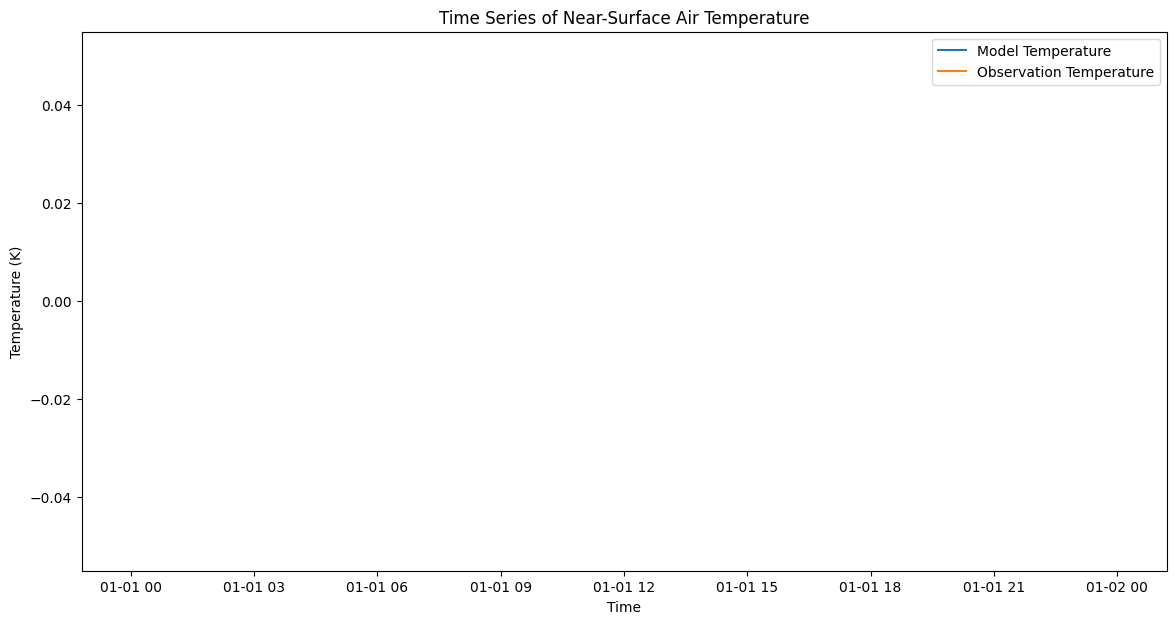

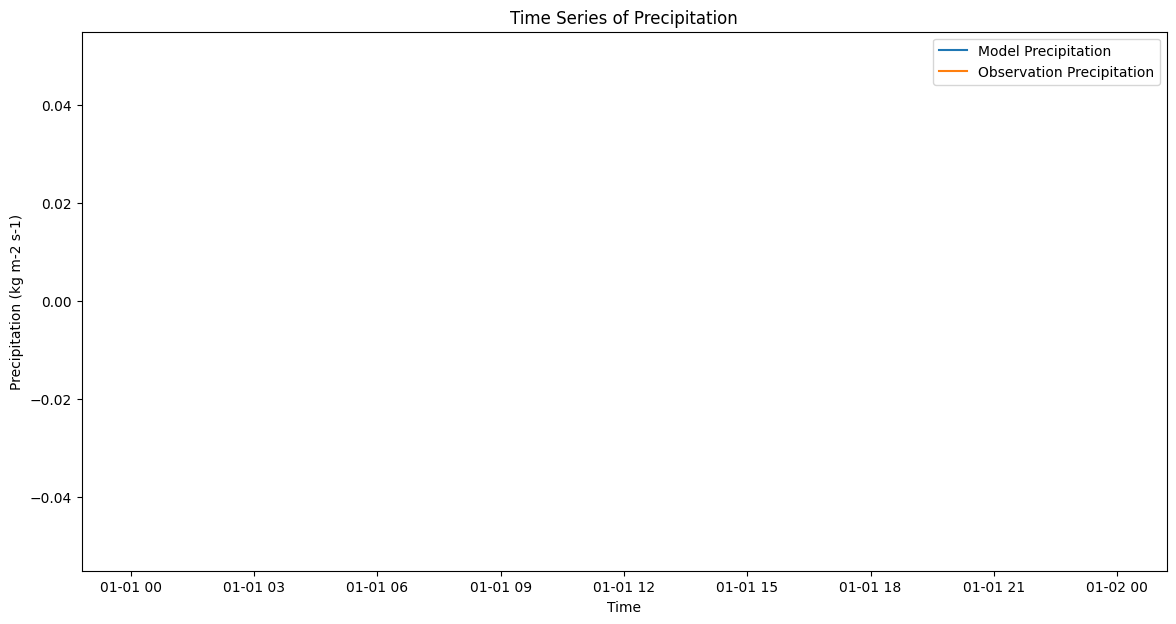

In [99]:

# Compute the mean over lat and lon for model data
model_temp_ts = model_subset.tas.mean(dim=['y', 'x'])
model_precip_ts = model_subset.pr.mean(dim=['y', 'x'])

# Compute the mean over lat and lon for observational data
obs_temp_ts = obs_subset.TEMP_AVG.mean(dim=['lat', 'lon'])
obs_precip_ts = obs_subset.PRECIP_QUANTITY.mean(dim=['lat', 'lon'])

# Trigger computation explicitly
model_temp_ts = model_temp_ts.compute()
model_precip_ts = model_precip_ts.compute()
obs_temp_ts = obs_temp_ts.compute()
obs_precip_ts = obs_precip_ts.compute()
print(model_temp_ts)
print(model_temp_ts.time)
# Plot the time series of temperature
plt.figure(figsize=(14, 7))
plt.plot(model_temp_ts.time, model_temp_ts, label='Model Temperature')
plt.plot(obs_temp_ts.time, obs_temp_ts, label='Observation Temperature')
plt.title('Time Series of Near-Surface Air Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

# Plot the time series of precipitation
plt.figure(figsize=(14, 7))
plt.plot(model_precip_ts.time, model_precip_ts, label='Model Precipitation')
plt.plot(obs_precip_ts.time, obs_precip_ts, label='Observation Precipitation')
plt.title('Time Series of Precipitation')
plt.xlabel('Time')
plt.ylabel('Precipitation (kg m-2 s-1)')
plt.legend()
plt.show()


# Subset: Spatial Analysis

# Subset: Statistical Evaluation

# Subset: seasonal and interannual 

Subset: EE

Drought Analysis

Water Budget Components